In [5]:
import os 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from scipy import sparse

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import Ridge
# from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from scipy.stats import randint
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
# from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import explained_variance_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
# hide warnings
import warnings
from joblib import dump, load

warnings.filterwarnings('ignore')


In [2]:
import contractions
import string
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

def preprocess(data_real, colum_name):
    def remove_punctuation(sentence):
        unnecessary_dict = {}
        for symb in string.punctuation:
            unnecessary_dict[symb] = ' '
        unnecessary_dict['\x96'] = ' '
        unnecessary_dict['\x85'] = ' '
        unnecessary_dict['´'] = ' '
        unnecessary_dict['\x97'] = ' '
        unnecessary_dict['…'] = ' '
        unnecessary_dict['’'] = ' '
        unnecessary_dict['\x91'] = ' '

        s = sentence.replace('<br />', '')
        s = s.translate(s.maketrans(unnecessary_dict))
        return s

    def remove_stopwords(sentence):
        without_sw = []
        stop_words = stopwords.words('english')
        stop_words.remove('not')
        stop_words.remove('no')
        
        words = sentence.split()
        for word in words:
            if word not in stop_words:
                without_sw.append(word)

        res = ' '.join(without_sw)
        return res

    def lemmatize_text(text):
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(w) for w in text.split()]
        return " ".join(words)
    
    data = data_real.copy()
    #all to lowercase
    data[colum_name] = data[colum_name].str.lower()
    #change contractions (i've, don't ...) to full forms (i have, do not)
    data[colum_name] = data[colum_name].apply(lambda x: " ".join([contractions.fix(word) for word in str(x).split()]))
    #remove punctuation
    data[colum_name] = data[colum_name].apply(remove_punctuation)
    #remove numbers
    data[colum_name] = data[colum_name].apply(lambda s: re.sub('\d+', ' ', s))
    #remove stopwords
    data[colum_name] = data[colum_name].apply(remove_stopwords)
    #remove single letters
    data[colum_name] = data[colum_name].apply(lambda s: re.sub('\b[a-zA-Z]\b', ' ', s))
    #remove excess spaces
    data[colum_name] = data[colum_name].apply(lambda s: re.sub(' +', ' ', s))
    #lemmatize
    data[colum_name] = data[colum_name].apply(lemmatize_text)
    #tokenize
    data[f'tokenized_{colum_name}'] = data[colum_name].apply(lambda s: s.split())
    #add number of words column
    data[f'word_num_{colum_name}'] = data[f'tokenized_{colum_name}'].str.len()
    
    return data

In [57]:
def define_metrics(model, X_train_, X_test_, y_train, y_test, name):
    pred_train_ = np.array(model.predict(X_train_))
    pred_test_ = np.array(model.predict(X_test_))
#     y_train_ = list(y_train)
#     y_test_ = list(y_test)

    metric_train = pd.DataFrame()
    metric_train['name'] = [name + '_train']
    metric_train['r2'] = [r2_score(y_train, pred_train_)]
    metric_train['MAPE'] = [np.mean(np.abs((y_train - pred_train_) / y_train)) * 100]
    metric_train['RMSE'] = [np.sqrt(np.sum((y_train - pred_train_)**2) / len(y_train))]
    metric_train['ex_var'] = [explained_variance_score(y_train, pred_train_)]
    metric_train['durbin_watson'] = [durbin_watson(y_train - pred_train_)]

    metric_test = pd.DataFrame()
    metric_test['name'] = [name + '_test']
    metric_test['r2'] = [r2_score(y_test, pred_test_)]
    metric_test['MAPE'] = [np.mean(np.abs((y_test - pred_test_) / y_test)) * 100]
    metric_test['RMSE'] = [np.sqrt(np.sum((y_test - pred_test_)**2) / y_test.shape[0])]
    metric_test['ex_var'] = [explained_variance_score(y_test, pred_test_)]
    metric_test['durbin_watson'] = [durbin_watson(y_test - pred_test_)]

    return metric_train.append(metric_test)

In [35]:
train_full = pd.read_csv('input/train.csv')
test_full = pd.read_csv('input/test.csv')

train_full = train_full.set_index('id')
test_full = test_full.set_index('id')

In [3]:
train_full.shape

(40000, 11)

In [4]:
test_full.shape

(3020, 10)

In [7]:
print(f'train_columns:\t {train_full.columns}')
print(f'test_columns:\t {test_full.columns}')

train_columns:	 Index(['id', 'book_title', 'book_image_url', 'book_desc', 'book_genre',
       'book_authors', 'book_format', 'book_pages', 'book_review_count',
       'book_rating_count', 'book_rating'],
      dtype='object')
test_columns:	 Index(['id', 'book_title', 'book_image_url', 'book_desc', 'book_genre',
       'book_authors', 'book_format', 'book_pages', 'book_review_count',
       'book_rating_count'],
      dtype='object')


In [13]:
test_full

,book_title,book_image_url,book_desc,book_genre,book_authors,book_format,book_pages,book_review_count,book_rating_count
id,,,,,,,,,
0,The Paper Wasp,https://i.gr-assets.com/images/S/compressed.ph...,An electrifying debut novel from the acclaimed...,Fiction|Contemporary|Thriller|Thriller|Mystery...,Lauren Acampora,Hardcover,289 pages,415,1587
1,The Old Success,https://i.gr-assets.com/images/S/compressed.ph...,When the body of a French woman washes up on a...,Mystery|Fiction|European Literature|British Li...,Martha Grimes,Hardcover,243 pages,409,2777
2,The Berlin Girl,https://i.gr-assets.com/images/S/compressed.ph...,From the bestselling author of The German Midw...,Historical|Historical Fiction|Fiction|War|Worl...,Mandy Robotham,Paperback,400 pages,270,1413
3,Bringing Down the Duke,https://i.gr-assets.com/images/S/compressed.ph...,One of Publishers Weekly's Most Anticipated Fa...,Romance|Historical|Historical Fiction|Romance|...,Evie Dunmore,Hardcover,356 pages,4926,32404
4,Horse Crazy: Girls and the Lives of Horses,https://i.gr-assets.com/images/S/compressed.ph...,Horse Crazy explores the meaning behind the lo...,Nonfiction|Psychology,Jean O'Malley Halley,Paperback,272 pages,7,11
...,...,...,...,...,...,...,...,...,...
3015,The End of Everything (Astrophysically Speaking),https://i.gr-assets.com/images/S/compressed.ph...,From one of the most dynamic rising stars in a...,Science|Nonfiction|Science|Physics|Science|Ast...,Katie Mack,Hardcover,240 pages,377,2104
3016,Saving Ruby King,https://i.gr-assets.com/images/S/compressed.ph...,"Set in the South Side of Chicago, an epic, ent...",Fiction|Mystery|Thriller|Mystery Thriller|Lite...,Catherine Adel West,Hardcover,352 pages,720,3017
3017,Pretending,https://i.gr-assets.com/images/S/compressed.ph...,WHY BE YOURSELF WHEN YOU CAN BE PERFECT?'Perce...,Fiction|Contemporary|Romance|Womens Fiction|Ch...,Holly Bourne,Hardcover,438 pages,563,5055


In [12]:
train_full

,book_title,book_image_url,book_desc,book_genre,book_authors,book_format,book_pages,book_review_count,book_rating_count,book_rating
id,,,,,,,,,,
0,Forastera,https://images.gr-assets.com/books/1500683049l...,"Recién acabada la Segunda Guerra Mundial, una ...",Historical|Historical Fiction|Romance|Fantasy|...,Diana Gabaldon|Carmen Bordeu,Kindle Edition,768 pages,40197,668892,4.22
1,Writing about Magic,https://images.gr-assets.com/books/1445900480l...,Do you write fantasy fiction? This book is a r...,Language|Writing|Nonfiction,Rayne Hall,Paperback,180 pages,27,126,3.95
2,The Stress of Her Regard,https://images.gr-assets.com/books/1503059955l...,When Michael Crawford discovers his bride brut...,Fantasy|Horror|Paranormal|Vampires|Historical|...,Tim Powers,Paperback,470 pages,331,3626,3.79
3,The Horrors and Absurdities of Religion,https://images.gr-assets.com/books/1409779869l...,"A fascinating examination of ethics, religion ...",Philosophy|Religion|Nonfiction|Classics,Arthur Schopenhauer,Paperback,106 pages,28,371,3.85
4,Three Tales,https://images.gr-assets.com/books/1311645483l...,"First published in 1877, these three stories a...",Fiction|Short Stories|Classics|Cultural|France...,Gustave Flaubert|Roger Whitehouse|Geoffrey Wall,Paperback,110 pages,250,4331,3.72
...,...,...,...,...,...,...,...,...,...,...
39995,Six of Crows,https://images.gr-assets.com/books/1442579137l...,Alternate cover edition for ISBN: 1780622279 /...,Fantasy|Young Adult,Leigh Bardugo,Paperback,491 pages,24661,165284,4.46
39996,What I Believe,https://images.gr-assets.com/books/1356456172l...,"Along with Why I Am Not a Christian, this essa...",Philosophy|Nonfiction|Religion|Writing|Essays|...,Bertrand Russell,Paperback,48 pages,130,1556,4.08
39997,This Time For Keeps: A wartime saga of tragedy...,https://images.gr-assets.com/books/1327873347l...,"Love and War, Passion amd heartache...When Bab...",Romance|Historical Romance|Historical|Historic...,Dee Williams,Paperback,416 pages,3,159,4.20


In [9]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 40000 non-null  int64  
 1   book_title         40000 non-null  object 
 2   book_image_url     39608 non-null  object 
 3   book_desc          40000 non-null  object 
 4   book_genre         37551 non-null  object 
 5   book_authors       40000 non-null  object 
 6   book_format        39080 non-null  object 
 7   book_pages         38141 non-null  object 
 8   book_review_count  40000 non-null  int64  
 9   book_rating_count  40000 non-null  int64  
 10  book_rating        40000 non-null  float64
dtypes: float64(1), int64(3), object(7)
memory usage: 3.4+ MB


In [10]:
test_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 3020 non-null   int64 
 1   book_title         3020 non-null   object
 2   book_image_url     3020 non-null   object
 3   book_desc          3020 non-null   object
 4   book_genre         3020 non-null   object
 5   book_authors       3020 non-null   object
 6   book_format        3020 non-null   object
 7   book_pages         3020 non-null   object
 8   book_review_count  3020 non-null   int64 
 9   book_rating_count  3020 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 236.1+ KB


In [152]:
train_full.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.95])

,book_review_count,book_rating_count,book_rating
count,40000.000000,4.000000e+04,40000.000000
mean,1531.852675,3.372366e+04,4.008422
std,6964.260581,1.987547e+05,0.369728
min,0.000000,0.000000e+00,0.000000
10%,5.000000,3.500000e+01,3.610000
25%,28.000000,3.050000e+02,3.810000
50%,130.000000,1.878500e+03,4.010000
75%,468.000000,6.928000e+03,4.210000
95%,5884.700000,8.865335e+04,4.550000
max,160776.000000,5.523413e+06,5.000000


## Explolary Data  Analysis

In [103]:
train_ful_new = train_full.drop('book_image_url', axis=1)

In [49]:
train_ful_new.columns.to_list()

['book_title',
 'book_desc',
 'book_genre',
 'book_authors',
 'book_format',
 'book_pages',
 'book_review_count',
 'book_rating_count',
 'book_rating']

### book_title

In [35]:
str(train_ful_new.book_genre[0])

'Historical|Historical Fiction|Romance|Fantasy|Fiction|Science Fiction|Time Travel|Historical|Romance|Historical Romance'

In [36]:
train_ful_new.book_genre[0].split('|')

['Historical',
 'Historical Fiction',
 'Romance',
 'Fantasy',
 'Fiction',
 'Science Fiction',
 'Time Travel',
 'Historical',
 'Romance',
 'Historical Romance']

In [105]:
to_str = ['book_title', 'book_desc', 'book_genre', 'book_authors', 'book_pages']

for name in to_str:
    train_ful_new[name] = train_full[name].apply(lambda x: str(x))

In [106]:
train_ful_new['book_genre_list'] = train_ful_new.book_genre.apply(lambda x: x.split('|') if x is not None else [] )
train_ful_new['book_authors_list'] = train_ful_new.book_authors.apply(lambda x: x.split('|') if x is not None else [])
train_ful_new.book_pages = train_ful_new['book_pages'].apply(lambda x: int(x.split()[0]) if len(x.split()) > 1 else np.nan)

train_ful_new = train_ful_new.drop(['book_genre', 'book_authors'], axis=1)

In [107]:
train_ful_new

,book_title,book_desc,book_format,book_pages,book_review_count,book_rating_count,book_rating,book_genre_list,book_authors_list
id,,,,,,,,,
0,Forastera,"Recién acabada la Segunda Guerra Mundial, una ...",Kindle Edition,768.0,40197,668892,4.22,"[Historical, Historical Fiction, Romance, Fant...","[Diana Gabaldon, Carmen Bordeu]"
1,Writing about Magic,Do you write fantasy fiction? This book is a r...,Paperback,180.0,27,126,3.95,"[Language, Writing, Nonfiction]",[Rayne Hall]
2,The Stress of Her Regard,When Michael Crawford discovers his bride brut...,Paperback,470.0,331,3626,3.79,"[Fantasy, Horror, Paranormal, Vampires, Histor...",[Tim Powers]
3,The Horrors and Absurdities of Religion,"A fascinating examination of ethics, religion ...",Paperback,106.0,28,371,3.85,"[Philosophy, Religion, Nonfiction, Classics]",[Arthur Schopenhauer]
4,Three Tales,"First published in 1877, these three stories a...",Paperback,110.0,250,4331,3.72,"[Fiction, Short Stories, Classics, Cultural, F...","[Gustave Flaubert, Roger Whitehouse, Geoffrey ..."
...,...,...,...,...,...,...,...,...,...
39995,Six of Crows,Alternate cover edition for ISBN: 1780622279 /...,Paperback,491.0,24661,165284,4.46,"[Fantasy, Young Adult]",[Leigh Bardugo]
39996,What I Believe,"Along with Why I Am Not a Christian, this essa...",Paperback,48.0,130,1556,4.08,"[Philosophy, Nonfiction, Religion, Writing, Es...",[Bertrand Russell]
39997,This Time For Keeps: A wartime saga of tragedy...,"Love and War, Passion amd heartache...When Bab...",Paperback,416.0,3,159,4.20,"[Romance, Historical Romance, Historical, Hist...",[Dee Williams]


# Explorary Data analysis

In [116]:
train_full.duplicated().any()

False

In [151]:
train_full

,book_title,book_image_url,book_desc,book_genre,book_authors,book_format,book_pages,book_review_count,book_rating_count,book_rating
id,,,,,,,,,,
0,Forastera,https://images.gr-assets.com/books/1500683049l...,"Recién acabada la Segunda Guerra Mundial, una ...",Historical|Historical Fiction|Romance|Fantasy|...,Diana Gabaldon|Carmen Bordeu,Kindle Edition,768 pages,40197,668892,4.22
1,Writing about Magic,https://images.gr-assets.com/books/1445900480l...,Do you write fantasy fiction? This book is a r...,Language|Writing|Nonfiction,Rayne Hall,Paperback,180 pages,27,126,3.95
2,The Stress of Her Regard,https://images.gr-assets.com/books/1503059955l...,When Michael Crawford discovers his bride brut...,Fantasy|Horror|Paranormal|Vampires|Historical|...,Tim Powers,Paperback,470 pages,331,3626,3.79
3,The Horrors and Absurdities of Religion,https://images.gr-assets.com/books/1409779869l...,"A fascinating examination of ethics, religion ...",Philosophy|Religion|Nonfiction|Classics,Arthur Schopenhauer,Paperback,106 pages,28,371,3.85
4,Three Tales,https://images.gr-assets.com/books/1311645483l...,"First published in 1877, these three stories a...",Fiction|Short Stories|Classics|Cultural|France...,Gustave Flaubert|Roger Whitehouse|Geoffrey Wall,Paperback,110 pages,250,4331,3.72
...,...,...,...,...,...,...,...,...,...,...
39995,Six of Crows,https://images.gr-assets.com/books/1442579137l...,Alternate cover edition for ISBN: 1780622279 /...,Fantasy|Young Adult,Leigh Bardugo,Paperback,491 pages,24661,165284,4.46
39996,What I Believe,https://images.gr-assets.com/books/1356456172l...,"Along with Why I Am Not a Christian, this essa...",Philosophy|Nonfiction|Religion|Writing|Essays|...,Bertrand Russell,Paperback,48 pages,130,1556,4.08
39997,This Time For Keeps: A wartime saga of tragedy...,https://images.gr-assets.com/books/1327873347l...,"Love and War, Passion amd heartache...When Bab...",Romance|Historical Romance|Historical|Historic...,Dee Williams,Paperback,416 pages,3,159,4.20


# ------------------------------------
# Features

In [140]:
train_full.columns.to_list()

['book_title',
 'book_image_url',
 'book_desc',
 'book_genre',
 'book_authors',
 'book_format',
 'book_pages',
 'book_review_count',
 'book_rating_count',
 'book_rating']

## book_title

In [145]:
train_full.book_title.value_counts()[:50]

Broken                                     12
Selected Poems                             12
American Gods                              11
1984                                       10
Hamlet                                     10
Inferno                                    10
A Christmas Carol                          10
The Hobbit                                  9
Little Women                                9
Sacrifice                                   9
Jane Eyre                                   9
Redemption                                  8
Hunted                                      8
Harry Potter and the Deathly Hallows        8
Pride and Prejudice                         8
Fahrenheit 451                              8
Lolita                                      7
The Great Gatsby                            7
It                                          7
Legacy                                      7
Burn                                        7
Haunted                           

In [146]:
train_full.book_title.value_counts()[-50:]

Karneval, Vol. 1                                                                                                                                       1
Schiava per vendetta                                                                                                                                   1
Wide Open                                                                                                                                              1
When We Collide                                                                                                                                        1
Ripped                                                                                                                                                 1
The Life-Changing Magic of Not Giving a F*ck: How to Stop Spending Time You Don't Have with People You Don't Like Doing Things You Don't Want to Do    1
The Wall of Winnipeg and Me                                                       

## book_image_url

In [148]:
train_full.book_image_url.value_counts()

https://images.gr-assets.com/books/1328323546l/13008316.jpg    1
https://images.gr-assets.com/books/1349041641l/313599.jpg      1
https://images.gr-assets.com/books/1408939449l/1053783.jpg     1
https://images.gr-assets.com/books/1391407997l/18513585.jpg    1
https://images.gr-assets.com/books/1388626977l/4783632.jpg     1
                                                              ..
https://images.gr-assets.com/books/1391525149l/20693377.jpg    1
https://images.gr-assets.com/books/1417605514l/859500.jpg      1
https://images.gr-assets.com/books/1174509809l/410370.jpg      1
https://images.gr-assets.com/books/1450822369l/28268831.jpg    1
https://images.gr-assets.com/books/1369617580l/17980328.jpg    1
Name: book_image_url, Length: 39608, dtype: int64

###  book_authors

In [149]:
train_full.book_authors.value_counts()[:50]

Nora Roberts              66
Agatha Christie           58
Stephen King              54
Bella Forrest             50
Bonnie Bryant             47
Anonymous                 47
Carolyn Keene             42
Terry Pratchett           37
George R.R. Martin        37
Idries Shah               35
Francis Okumu             34
J.D. Robb                 33
Cynthia Harrod-Eagles     33
Enid Blyton               33
James Hadley Chase        33
Mark Crilley              32
Piers Anthony             32
Orson Scott Card          32
Terry Brooks              32
Rick Riordan              32
Karen Kingsbury           31
Alexa Riley               30
R.L. Stine                30
Pet Torres                30
Christine Feehan          30
Francine Pascal           30
Jessica Sorensen          29
Mercedes Lackey           29
Danielle Steel            29
P.G. Wodehouse            28
Linda Howard              28
Emily Brightwell          28
Elite Summaries           27
Cassandra Clare           27
Arthur Conan D

In [150]:
train_full.book_authors.value_counts()[-50:]

Anna Zaires                                                                                                                                                                        1
P.W. Singer                                                                                                                                                                        1
Peter J. Tomasi                                                                                                                                                                    1
Karen Kondazian                                                                                                                                                                    1
Mil Millington                                                                                                                                                                     1
E.R. Frank                                                                                     

### book_genre

In [131]:
train_full.book_genre.value_counts()[:50]

Fiction                                                                        164
Romance                                                                        125
Science Fiction|Fiction                                                        125
Childrens                                                                      100
Fantasy                                                                         97
Romance|Romance|Contemporary Romance|Contemporary                               92
Nonfiction                                                                      89
Historical|Historical Fiction|Fiction|Historical                                73
Poetry                                                                          72
Fantasy|Fiction|Fantasy|Epic Fantasy                                            70
Fantasy|Young Adult|Fiction                                                     67
Science Fiction|Fiction|Space|Space Opera                                       62
Fant

In [139]:
train_full.book_genre.value_counts()[-50:]

Fantasy|Young Adult|Childrens|Fiction|Animals                                                                                                         1
Philosophy|Nonfiction|Philosophy|Theory|Writing|Essays|Cultural|France|Fantasy|Mythology                                                              1
Erotica|Bdsm|Romance|M M Romance|Erotica|Menage|Fantasy|Romance|Sociology|Abuse                                                                       1
Poetry|Classics|Literature|Fiction|Religion                                                                                                           1
Nonfiction|Fantasy|Paranormal|Occult                                                                                                                  1
Romance|Romance|Contemporary Romance|Novella|Contemporary                                                                                             1
Religion|Religion|Judaism|Spirituality|Occult|Literature|Jewish|Nonfiction              

### book_pages

In [134]:
train_full.book_pages.value_counts()[:50]

320 pages    855
352 pages    706
288 pages    687
256 pages    639
304 pages    632
384 pages    624
336 pages    589
224 pages    561
240 pages    507
368 pages    503
192 pages    495
272 pages    474
400 pages    472
208 pages    417
416 pages    396
160 pages    335
432 pages    334
448 pages    306
144 pages    293
128 pages    283
176 pages    280
32 pages     231
480 pages    219
464 pages    210
512 pages    205
96 pages     195
200 pages    194
0 pages      166
496 pages    160
112 pages    154
300 pages    148
280 pages    147
264 pages    144
296 pages    140
248 pages    134
310 pages    133
528 pages    123
328 pages    123
344 pages    121
308 pages    121
312 pages    120
216 pages    118
80 pages     118
544 pages    117
560 pages    116
232 pages    114
184 pages    114
64 pages     113
360 pages    112
324 pages    112
Name: book_pages, dtype: int64

In [137]:
train_full.book_pages.value_counts()[-50:]

1810 pages    1
958 pages     1
1455 pages    1
1705 pages    1
1065 pages    1
1228 pages    1
3920 pages    1
1082 pages    1
2149 pages    1
1507 pages    1
1077 pages    1
2080 pages    1
1262 pages    1
1632 pages    1
1213 pages    1
1495 pages    1
1299 pages    1
1012 pages    1
869 pages     1
1410 pages    1
961 pages     1
1094 pages    1
1423 pages    1
977 pages     1
1600 pages    1
790 pages     1
4736 pages    1
1272 pages    1
942 pages     1
1190 pages    1
1221 pages    1
2024 pages    1
2346 pages    1
2549 pages    1
929 pages     1
1684 pages    1
949 pages     1
2676 pages    1
1536 pages    1
1508 pages    1
1504 pages    1
2399 pages    1
982 pages     1
806 pages     1
1064 pages    1
1861 pages    1
1182 pages    1
1080 pages    1
1019 pages    1
879 pages     1
Name: book_pages, dtype: int64

## book_review_count

In [141]:
train_full.book_review_count.value_counts()[:50]

0     1058
1      981
2      708
3      604
4      522
5      452
6      385
9      361
7      349
8      347
10     341
12     284
13     280
17     277
11     274
14     266
16     237
18     233
20     223
19     218
15     215
21     199
22     195
25     189
26     182
24     179
27     178
37     176
29     176
30     176
23     172
28     169
33     163
31     156
45     153
32     153
42     153
46     152
39     150
40     147
36     146
34     146
38     146
41     140
44     138
52     136
35     133
51     132
48     128
43     124
Name: book_review_count, dtype: int64

In [142]:
train_full.book_review_count.value_counts()[-50:]

5404     1
10409    1
4238     1
2590     1
36900    1
25874    1
10842    1
6223     1
26683    1
4180     1
3327     1
2135     1
14449    1
5705     1
2327     1
2359     1
3210     1
11502    1
21084    1
3274     1
64105    1
3242     1
1163     1
17539    1
5385     1
13421    1
7272     1
29797    1
6773     1
14993    1
44030    1
4692     1
3338     1
4436     1
3530     1
7720     1
1547     1
12688    1
33190    1
3562     1
37316    1
19906    1
53836    1
2551     1
64916    1
4628     1
3434     1
1355     1
13613    1
10570    1
Name: book_review_count, dtype: int64

## book_format

In [154]:
train_full.book_format.value_counts()[:50]

Paperback                      21209
Hardcover                       8607
Kindle Edition                  4492
ebook                           2079
Mass Market Paperback           1814
Audio CD                         136
Nook                             114
Audiobook                         92
Unknown Binding                   71
Audible Audio                     55
Trade Paperback                   43
Library Binding                   35
Audio Cassette                    29
Leather Bound                     21
Audio                             21
paperback                         17
Board Book                        16
Board book                        13
Taschenbuch                       12
Mass Market                       11
Poche                             10
paper                              9
Broché                             8
Hardback                           7
Capa Mole                          7
cloth                              6
MP3 CD                             6
K

In [157]:
train_full.book_format.value_counts()[-50:]

Box-Set                              1
Bolsillo                             1
Digital Comic                        1
Bonded Leather                       1
Hardcover Chapbook                   1
Pocket                               1
capa mole                            1
online serial                        1
Hardbound                            1
free online                          1
Capa dura                            1
Diary                                1
Mass Market Paperback                1
Gebundene Ausgabe                    1
Hardcover im Schuber                 1
Paperback/Ebook                      1
Online Fiction - Complete            1
softcover                            1
Edición Kindle                       1
PDF                                  1
Paperback, Kindle, Ebook, Audio      1
Paperback, eBook                     1
Capa comum                           1
Novel                                1
Hard cover, Soft cover, e-book       1
Audio Book               

In [ ]:
train_full.boo

In [ ]:
train_ful_new.book_pages = train_ful_new['book_pages'].apply(lambda x: int(x.split()[0]) if len(x.split()) > 1 else np.nan)

In [173]:
train_full.head()

,book_title,book_image_url,book_desc,book_genre,book_authors,book_format,book_pages,book_review_count,book_rating_count,book_rating
id,,,,,,,,,,
0,Forastera,https://images.gr-assets.com/books/1500683049l...,"Recién acabada la Segunda Guerra Mundial, una ...",Historical|Historical Fiction|Romance|Fantasy|...,Diana Gabaldon|Carmen Bordeu,Kindle Edition,768 pages,40197,668892,4.22
1,Writing about Magic,https://images.gr-assets.com/books/1445900480l...,Do you write fantasy fiction? This book is a r...,Language|Writing|Nonfiction,Rayne Hall,Paperback,180 pages,27,126,3.95
2,The Stress of Her Regard,https://images.gr-assets.com/books/1503059955l...,When Michael Crawford discovers his bride brut...,Fantasy|Horror|Paranormal|Vampires|Historical|...,Tim Powers,Paperback,470 pages,331,3626,3.79
3,The Horrors and Absurdities of Religion,https://images.gr-assets.com/books/1409779869l...,"A fascinating examination of ethics, religion ...",Philosophy|Religion|Nonfiction|Classics,Arthur Schopenhauer,Paperback,106 pages,28,371,3.85
4,Three Tales,https://images.gr-assets.com/books/1311645483l...,"First published in 1877, these three stories a...",Fiction|Short Stories|Classics|Cultural|France...,Gustave Flaubert|Roger Whitehouse|Geoffrey Wall,Paperback,110 pages,250,4331,3.72


In [219]:
del_columns = ['book_title', 'book_desc', 'book_genre', 'book_authors', 'book_format']

data_new = preprocess(train_full, 'book_desc')

data_new['book_genre_list'] = data_new['book_genre'].apply(lambda x: list(set((" ".join(str(x).split('|'))).split())) if x is not None else [])

data_new['book_authors_list'] = data_new['book_authors'].apply(lambda x: list(set((" ".join(str(x).split('|'))).split())) if x is not None else [])

data_new.book_format = data_new.book_format.fillna(data_new.book_format.mode())

data_new = preprocess(data_new, 'book_format')

data_new.book_pages = data_new['book_pages'].apply(lambda x: int(x.split()[0]) if len(str(x).split()) > 1 else np.nan)

data_new = preprocess(data_new, 'book_title')

In [220]:
data_new

,book_title,book_image_url,book_desc,book_genre,book_authors,book_format,book_pages,book_review_count,book_rating_count,book_rating,tokenized_book_desc,word_num_book_desc,book_genre_list,book_authors_list,tokenized_book_format,word_num_book_format,tokenized_book_title,word_num_book_title
id,,,,,,,,,,,,,,,,,,
0,forastera,https://images.gr-assets.com/books/1500683049l...,recién acabada la segunda guerra mundial una j...,Historical|Historical Fiction|Romance|Fantasy|...,Diana Gabaldon|Carmen Bordeu,kindle edition,166.0,40197,668892,4.22,"[recién, acabada, la, segunda, guerra, mundial...",161,"[Fantasy, Science, Travel, Fiction, Historical...","[Diana, Gabaldon, Carmen, Bordeu]","[kindle, edition]",2,[forastera],1
1,writing magic,https://images.gr-assets.com/books/1445900480l...,write fantasy fiction book resource author cra...,Language|Writing|Nonfiction,Rayne Hall,paperback,17.0,27,126,3.95,"[write, fantasy, fiction, book, resource, auth...",9,"[Language, Writing, Nonfiction]","[Hall, Rayne]",[paperback],1,"[writing, magic]",2
2,stress regard,https://images.gr-assets.com/books/1503059955l...,michael crawford discovers bride brutally murd...,Fantasy|Horror|Paranormal|Vampires|Historical|...,Tim Powers,paperback,5.0,331,3626,3.79,"[michael, crawford, discovers, bride, brutally...",54,"[Horror, Fantasy, Fiction, Historical, Paranor...","[Tim, Powers]",[paperback],1,"[stress, regard]",2
3,horror absurdity religion,https://images.gr-assets.com/books/1409779869l...,fascinating examination ethic religion psychol...,Philosophy|Religion|Nonfiction|Classics,Arthur Schopenhauer,paperback,10.0,28,371,3.85,"[fascinating, examination, ethic, religion, ps...",57,"[Philosophy, Classics, Nonfiction, Religion]","[Schopenhauer, Arthur]",[paperback],1,"[horror, absurdity, religion]",3
4,three tale,https://images.gr-assets.com/books/1311645483l...,first published three story dominated question...,Fiction|Short Stories|Classics|Cultural|France...,Gustave Flaubert|Roger Whitehouse|Geoffrey Wall,paperback,13.0,250,4331,3.72,"[first, published, three, story, dominated, qu...",67,"[Cultural, Fiction, Stories, 19th, Classics, C...","[Roger, Wall, Whitehouse, Flaubert, Gustave, G...",[paperback],1,"[three, tale]",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,six crow,https://images.gr-assets.com/books/1442579137l...,alternate cover edition isbn criminal prodigy ...,Fantasy|Young Adult,Leigh Bardugo,paperback,NaN,24661,165284,4.46,"[alternate, cover, edition, isbn, criminal, pr...",65,"[Adult, Fantasy, Young]","[Bardugo, Leigh]",[paperback],1,"[six, crow]",2
39996,believe,https://images.gr-assets.com/books/1356456172l...,along not christian essay must rank articulate...,Philosophy|Nonfiction|Religion|Writing|Essays|...,Bertrand Russell,paperback,NaN,130,1556,4.08,"[along, not, christian, essay, must, rank, art...",46,"[Writing, Atheism, Philosophy, Essays, Religio...","[Bertrand, Russell]",[paperback],1,[believe],1
39997,time keep wartime saga tragedy forbidden love,https://images.gr-assets.com/books/1327873347l...,love war passion amd heartache babs scott lose...,Romance|Historical Romance|Historical|Historic...,Dee Williams,paperback,NaN,3,159,4.20,"[love, war, passion, amd, heartache, babs, sco...",89,"[War, II, Fiction, Historical, World, Romance]","[Dee, Williams]",[paperback],1,"[time, keep, wartime, saga, tragedy, forbidden...",7


In [227]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   book_title         40000 non-null  object 
 1   book_image_url     39608 non-null  object 
 2   book_desc          40000 non-null  object 
 3   book_genre         37551 non-null  object 
 4   book_authors       40000 non-null  object 
 5   book_format        39080 non-null  object 
 6   book_pages         38141 non-null  object 
 7   book_review_count  40000 non-null  int64  
 8   book_rating_count  40000 non-null  int64  
 9   book_rating        40000 non-null  float64
dtypes: float64(1), int64(2), object(7)
memory usage: 4.6+ MB


In [229]:
data_new.drop(del_columns, axis=1).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   book_image_url         39608 non-null  object 
 1   book_pages             38141 non-null  float64
 2   book_review_count      40000 non-null  int64  
 3   book_rating_count      40000 non-null  int64  
 4   book_rating            40000 non-null  float64
 5   tokenized_book_desc    40000 non-null  object 
 6   word_num_book_desc     40000 non-null  int64  
 7   book_genre_list        40000 non-null  object 
 8   book_authors_list      40000 non-null  object 
 9   tokenized_book_format  40000 non-null  object 
 10  word_num_book_format   40000 non-null  int64  
 11  tokenized_book_title   40000 non-null  object 
 12  word_num_book_title    40000 non-null  int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 4.3+ MB


# Creating PipeLine

In [33]:

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


del_columns = ['book_title', 'book_desc', 'book_genre', 'book_authors', 'book_format']

class CleaningTextData(BaseEstimator, TransformerMixin):
    def __init__(self, del_columns=del_columns):
        self.del_columns = del_columns 
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        data_new = X.copy()
        
        # cleaning 
        data_new = preprocess(data_new, 'book_desc')
        data_new['book_genre_list'] = data_new['book_genre'].apply(lambda x: list(set((" ".join(str(x).split('|'))).split())) if x is not None else ['ok'])
        data_new['book_authors_list'] = data_new['book_authors'].apply(lambda x: list(set((" ".join(str(x).split('|'))).split())) if x is not None else ['ok'])
        data_new.book_format = data_new.book_format.fillna(data_new.book_format.mode())
        data_new = preprocess(data_new, 'book_format')
        data_new.book_pages = data_new['book_pages'].apply(lambda x: int(x.split()[0]) if len(str(x).split()) > 1 else np.nan)
        data_new = preprocess(data_new, 'book_title')
        data_new = data_new.drop(self.del_columns, axis=1)
        
        # to string some columns
        self.columns_str = ['tokenized_book_desc', 'book_genre_list', 'book_authors_list', 'tokenized_book_format', 'tokenized_book_title']
        
        for name in self.columns_str:
            data_new[name] = data_new[name].apply(lambda x: np.nan if len(x)==0 or x[0] == 'ok' else ' '.join(x))
            
        # come back to nan
        columns_back = ['book_image_url',
                         'tokenized_book_desc',
                         'word_num_book_desc',
                         'book_genre_list',
                         'book_authors_list',
                         'tokenized_book_format',
                         'tokenized_book_title']
        
        for name in columns_back:
            data_new[name] = data_new[name].apply(lambda x: np.nan if x == 'nan' else x)
            
        return data_new
    
class FillingNaN(BaseEstimator, TransformerMixin):
    def __init__(self, strategy='most_frequent'):
        self.strategy = strategy
#         self.columns_input = columns_input
        
    def fit(self, X, y=None):
        print('fit filling na')

        data = X.copy()
        
        self.imputer = SimpleImputer(strategy=self.strategy)
        self.imputer.fit(data)
        
        return self
    
    def transform(self, X):
        data = X.copy()
        data_subset_transformed = self.imputer.transform(data)
        data = pd.DataFrame(data_subset_transformed, columns=data.columns)
        
        return data

    
columns_idf = ['tokenized_book_desc', 'book_genre_list', 'book_authors_list', 'tokenized_book_format', 'tokenized_book_title']

class TfIdf(BaseEstimator, TransformerMixin):
    def __init__(self, columns_idf=columns_idf, max_features=10000):
        self.columns_idf = columns_idf
        self.max_features = max_features
        self.model_dic = {}

    def fit(self, X, y=None):
        print('fit tfidf')
        data = X.copy()
        
        for name in self.columns_idf:
            self.model_dic[name] = TfidfVectorizer(stop_words='english', max_features=self.max_features)
            self.model_dic[name].fit(data[name].values)
        return self
    
    def transform(self, X, y=None):
        data = X.copy()
        data_new = data.copy()
        
        for name, model in self.model_dic.items():
            print
            data_transformed = model.transform(data[name].values).toarray()
            data_transformed = pd.DataFrame(data_transformed, columns=[f'{name}_{x}' for x in range(data_transformed.shape[1])])
            data_new = pd.concat([data_new, data_transformed], axis=1)
        
        data_new = data_new.drop(list(self.model_dic.keys()) + ['book_image_url'], axis=1)
        
        return data_new

In [43]:
name = 'pipelines/fillNa'
dump(cleaning_pipe_line, f'{name}.joblib') 

['pipelines/fillNa.joblib']

In [9]:
name = 'pipelines/dft_idf.joblib'
cleaning_pipe_line = load(name)

In [36]:
# train_x = train_full.drop(['book_rating'], axis=1)
# y = train_full.book_rating

X_train, X_test, y_train, y_test = train_test_split(train_full.drop(['book_rating'], axis=1), train_full.book_rating, test_size=0.1, random_state=13)

# X_train_sub, X_test_sub, y_train_sub, y_test_sub  = train_test_split(X_train, y_train, test_size=0.2, random_state=13)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
# print(f'X_train_sub shape: {X_train_sub.shape}')
# print(f'X_test_sub shape: {X_test_sub.shape}')

X_train shape: (36000, 9)
X_test shape: (4000, 9)


In [37]:
%%time

cleaning_pipe_line = Pipeline([('cleanText', CleaningTextData()),
                              ('fillNa', FillingNaN()),
                               
                              ('td_idf', TfIdf(max_features=200))])

cleaning_pipe_line.fit(X_train)

if True:
    name = 'pipelines/dft_idf_200'
    dump(cleaning_pipe_line, f'{name}.joblib')

fit filling na
fit tfidf
CPU times: user 2min 6s, sys: 959 ms, total: 2min 7s
Wall time: 2min 7s


In [38]:
train_pipeline = cleaning_pipe_line.transform(X_train)
test_pipeline = cleaning_pipe_line.transform(X_test)
submit_pipe = cleaning_pipe_line.transform(test_full)

In [39]:
train_pipeline['book_rating'] = y_train.values
test_pipeline['book_rating'] = y_test.values

train_pipeline.to_csv('pretrained_data/train_pipe_200.csv', index=False)
test_pipeline.to_csv('pretrained_data/test_pipe_200.csv', index=False)
submit_pipe.to_csv('pretrained_data/submit_pipe_200.csv', index=False)

In [40]:
train_pipeline.shape

(36000, 906)

In [26]:
y_train.values.shape

(36000,)

In [41]:
train_pipeline

,book_pages,book_review_count,book_rating_count,word_num_book_desc,word_num_book_format,word_num_book_title,tokenized_book_desc_0,tokenized_book_desc_1,tokenized_book_desc_2,tokenized_book_desc_3,...,tokenized_book_title_191,tokenized_book_title_192,tokenized_book_title_193,tokenized_book_title_194,tokenized_book_title_195,tokenized_book_title_196,tokenized_book_title_197,tokenized_book_title_198,tokenized_book_title_199,book_rating
0,320,624,3906,109,1,2,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.19
1,356,122,700,72,1,1,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.87
2,434,907,6709,114,1,3,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.67
3,358,160,4892,42,1,2,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.97
4,244,2,3,76,1,5,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,272,38,1676,95,1,3,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.98
35996,384,2324,14708,92,1,1,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.38
35997,352,912,5258,94,1,2,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.41
35998,224,55,1194,66,1,2,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.33


In [42]:
print(f'train_pipeline shape: {train_pipeline.shape}')
print(f'test_pipeline shape: {test_pipeline.shape}')

train_pipeline shape: (36000, 906)
test_pipeline shape: (4000, 906)


## To sparsity

In [44]:
train_pipeline= pd.read_csv('pretrained_data/train_pipe_200.csv').astype('float')
test_pipeline = pd.read_csv('pretrained_data/test_pipe_200.csv').astype('float')

train_pipeline_x = train_pipeline.drop(['book_rating'], axis=1)
test_pipeline_x = test_pipeline.drop(['book_rating'], axis=1)

y_train = train_pipeline['book_rating'].values
y_test = test_pipeline['book_rating'].values

In [33]:
X = X.astype('float')

In [45]:
# columns_naame = train_pipeline.columns
# X = train_pipeline.drop(['book_rating'], axis=1)
train_sparsity = sparse.csc_matrix(train_pipeline_x)



In [82]:
submit_pipe = pd.read_csv('pretrained_data/submit_pipe_200.csv',)
submit_sparsity = sparse.csc_matrix(submit_pipe)

In [61]:
test_sparsity = sparse.csc_matrix(test_pipeline_x)


In [46]:
train_sparsity

<36000x905 sparse matrix of type '<class 'numpy.float64'>'
	with 970410 stored elements in Compressed Sparse Column format>

In [21]:
from sklearn.model_selection import KFold

def get_score_for_model(models, X_train, y_train, n_splits=10, scoring='roc_auc', print_res=True):
    def append_res_to_boxplot():
        i = 0
        df = pd.DataFrame()
        while i < len(results[0]):
            line = [[num[i], ml] for num, ml in zip(results, names)]
            #             for num, ml in zip(results, names):
            #                 line.append([num[i],ml])
            i = i + 1
            df = df.append(pd.DataFrame(line, columns=[scoring, 'ML']), ignore_index=True)
        return df

    seed = 13

    results = []
    means = []
    sdv = []
    names = []
    scoring = scoring

    for name, model in models:
#         print(f'model:\t{name}')
        strat = KFold(n_splits=n_splits, random_state=seed, shuffle=True)

        cv_results = cross_val_score(model, X_train, y_train, cv=strat, scoring=scoring, n_jobs=-1)

        results.append(cv_results)
        names.append(name)
        means.append(cv_results.mean())
        sdv.append(cv_results.std())

        if print_res:
            print(f"{names[-1]}: {means[-1]} ({sdv[-1]})")

    box_plot = append_res_to_boxplot()

    df_means = pd.DataFrame({'ML': names, 'means': means, 'std': sdv})
    return box_plot, df_means

## 500 

In [23]:
%%time
models = []

models.append(('LogisticRegression', LogisticRegression()))
models.append(('SGDRegressor', SGDRegressor()))
models.append(('LinearSVR', LinearSVR()))
models.append(('SGDRegressor', SGDRegressor()))
models.append(('GradientBoostingRegressor', GradientBoostingRegressor()))
models.append(('RandomForestRegressor', RandomForestRegressor()))
models.append(('XGBRegressor', XGBRegressor()))
models.append(('XGBRFRegressor', XGBRFRegressor()))
models.append(('SVR', SVR()))

box_plot, df_means = get_score_for_model(models, train_sparsity, y_train, n_splits=3,scoring='neg_mean_absolute_error', print_res=True)

model:	LogisticRegression
LogisticRegression: nan (nan)
model:	SGDRegressor
SGDRegressor: -7.682310268128843e+18 (3.1078012028628337e+18)
model:	LinearSVR
LinearSVR: -22.40858707644316 (13.164729369925968)
model:	SGDRegressor
SGDRegressor: -1.4050716580880153e+19 (1.9018503084678615e+19)
model:	GradientBoostingRegressor
GradientBoostingRegressor: -0.22059322684251995 (0.0007931694216427363)
model:	RandomForestRegressor
RandomForestRegressor: -0.20354600833333333 (0.001503698377381192)
model:	XGBRegressor
XGBRegressor: -0.2089079709908035 (0.0009696418917326831)
model:	XGBRFRegressor
XGBRFRegressor: -0.23146764321996105 (0.0008227643320648858)
model:	SVR
SVR: -0.25911928203659185 (0.0016054762539227442)
CPU times: user 517 ms, sys: 445 ms, total: 962 ms
Wall time: 19min 12s


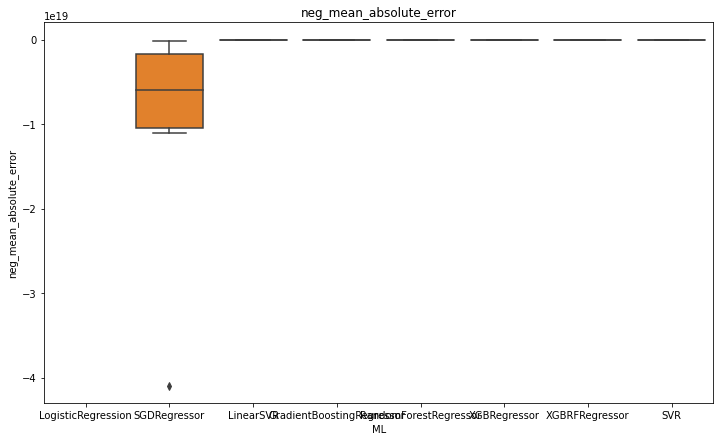

In [24]:
plt.figure(figsize=(12,7))
plt.title("neg_mean_absolute_error")
sns.boxplot(data = box_plot, x = box_plot.columns[1],y=box_plot.columns[0]);

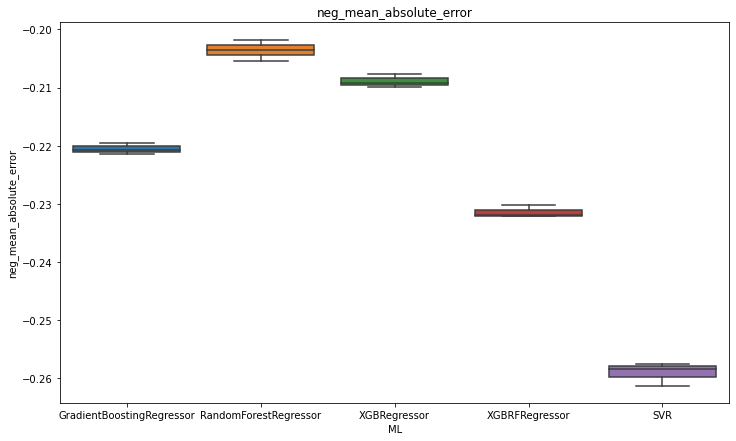

In [26]:
box_plot = box_plot[box_plot['ML'] != 'SGDRegressor']
box_plot = box_plot[box_plot['ML'] != 'LogisticRegression']
box_plot = box_plot[box_plot['ML'] != 'LinearSVR']


plt.figure(figsize=(12,7))
plt.title("neg_mean_absolute_error")
sns.boxplot(data = box_plot, x = box_plot.columns[1],y=box_plot.columns[0]);

## 200 

In [49]:
%%time
models = []

# models.append(('LogisticRegression', LogisticRegression()))
# models.append(('SGDRegressor', SGDRegressor()))
# models.append(('LinearSVR', LinearSVR()))
# models.append(('SGDRegressor', SGDRegressor()))
models.append(('GradientBoostingRegressor', GradientBoostingRegressor()))
models.append(('RandomForestRegressor', RandomForestRegressor()))
models.append(('XGBRegressor', XGBRegressor()))
models.append(('XGBRFRegressor', XGBRFRegressor()))
# models.append(('SVR', SVR()))

box_plot, df_means = get_score_for_model(models, train_sparsity, y_train, n_splits=3,scoring='neg_mean_absolute_error', print_res=True)

model:	GradientBoostingRegressor
GradientBoostingRegressor: -0.22051925629660452 (0.0008592688992240297)
model:	RandomForestRegressor
RandomForestRegressor: -0.20411303888888888 (0.0018137333149337582)
model:	XGBRegressor
XGBRegressor: -0.20924302574882903 (0.0013290671465558792)
model:	XGBRFRegressor
XGBRFRegressor: -0.23139478139496514 (0.0011324510470923945)
CPU times: user 220 ms, sys: 481 ms, total: 701 ms
Wall time: 12min 30s


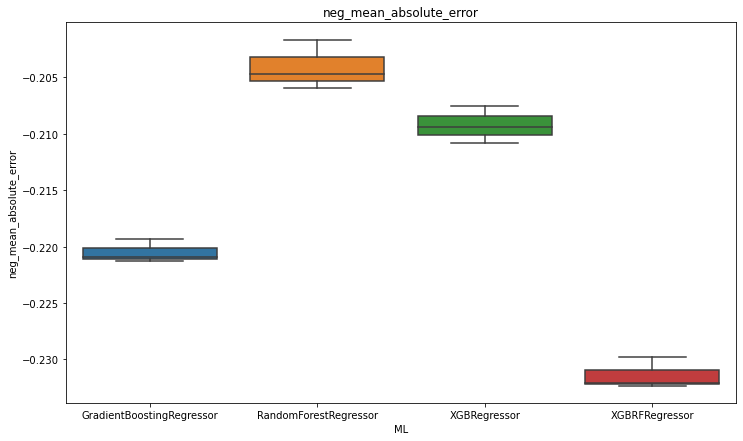

In [50]:
plt.figure(figsize=(12,7))
plt.title("neg_mean_absolute_error")
sns.boxplot(data = box_plot, x = box_plot.columns[1],y=box_plot.columns[0]);

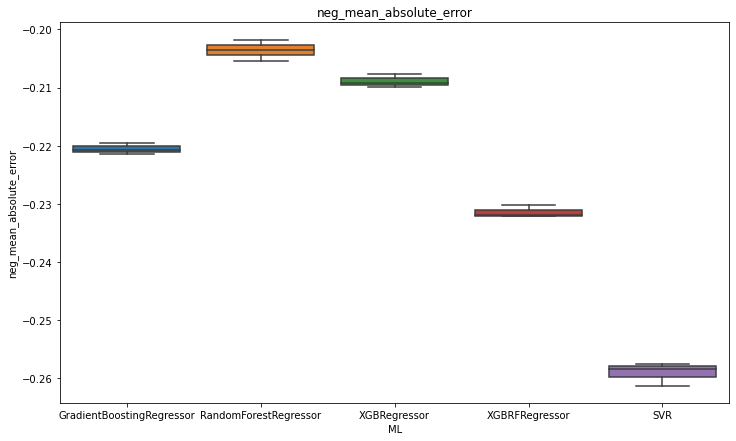

In [26]:
box_plot = box_plot[box_plot['ML'] != 'SGDRegressor']
box_plot = box_plot[box_plot['ML'] != 'LogisticRegression']
box_plot = box_plot[box_plot['ML'] != 'LinearSVR']


plt.figure(figsize=(12,7))
plt.title("neg_mean_absolute_error")
sns.boxplot(data = box_plot, x = box_plot.columns[1],y=box_plot.columns[0]);

# Training the best models 
- RandomForestRegressor
- XGBRFRegressor
- GradientBoostingRegressor
- XGBRFRegressor
- SVR

## Fiting RandomForestRegressor

In [ ]:
%%time
rfr = RandomForestRegressor()
grid = {

'n_estimators': [100],#np.linspace(100 ,150, 2, dtype=int),
'criterion' :['mse', 'mae'],
'max_features' :['auto'],
'max_depth' :  [5],
'warm_start' : [False],
'ccp_alpha': [0.1,0.2,0.3]
}

n_splits = 3
clf6 = GridSearchCV(rfr, grid, n_jobs=-1,
                  cv=KFold(n_splits=n_splits, shuffle=True),
                  scoring='neg_mean_absolute_error',
                  verbose=5, refit=True)
clf6.fit(train_sparsity, y_train)

print()
print(clf6.best_params_)
print(clf6.best_score_)
print(clf6.best_estimator_)

name='RandomForestRegressor'
model = clf6
score_model = define_metrics(model, train_sparsity, test_sparsity, y_train, y_test, name)
score_model

## Fitting XGBRegressor

In [ ]:
%%time
xgb = XGBRegressor()
grid = {
    'eval_metric': ['mae'],
    'n_estimators':np.linspace(100 ,1000, 5, dtype=int),
    'max_depth' :[3,4,5]
#     'gamma' : [0,0.1,0.5,1]
}



n_splits = 3
clf9 = GridSearchCV(xgb, grid, n_jobs=-1,
                  cv=KFold(n_splits=n_splits, shuffle=True),
                  scoring='neg_mean_absolute_error',
                  verbose=4, refit=True)
clf9.fit(train_sparsity, y_train)


print()
print(clf9.best_params_)
print(clf9.best_score_)
print(clf9.best_estimator_)

name='XGBRegressor'
model = clf9
score_model = define_metrics(model, train_sparsity, test_sparsity, y_train, y_test, name)
score_model

In [64]:
print()
print(clf9.best_params_)
print(clf9.best_score_)
print(clf9.best_estimator_)

name='XGBRegressor'
model = clf9
score_model = define_metrics(model, train_sparsity, test_sparsity, y_train, y_test, name)
score_model


{'eval_metric': 'mae', 'max_depth': 4, 'n_estimators': 325}
-0.20956028459820483
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=325, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


,name,r2,MAPE,RMSE,ex_var,durbin_watson
0,XGBRegressor_train,0.636338,inf,0.222969,0.636338,2.011863
0,XGBRegressor_test,0.410170,inf,0.283826,0.410512,1.993067


In [71]:
%%time
xgb = XGBRegressor()
grid = {
    'eval_metric': ['mae', 'rmse'],
    'n_estimators':np.linspace(300 ,400, 4, dtype=int),
    'max_depth' :[4]
#     'gamma' : [0,0.1,0.5,1, 10]
}



n_splits = 3
clf91 = GridSearchCV(xgb, grid, n_jobs=-1,
                  cv=KFold(n_splits=n_splits, shuffle=True),
                  scoring='neg_mean_absolute_error',
                  verbose=4, refit=True)
clf91.fit(train_sparsity, y_train)


print()
print(clf91.best_params_)
print(clf91.best_score_)
print(clf91.best_estimator_)

name='XGBRegressor'
model = clf91
score_model = define_metrics(model, train_sparsity, test_sparsity, y_train, y_test, name)
score_model

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done   8 out of  24 | elapsed:  1.2min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  15 out of  24 | elapsed:  2.0min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:  2.4min remaining:   12.9s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.4min finished



{'eval_metric': 'mae', 'max_depth': 4, 'n_estimators': 300}
-0.21014267516854737
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
CPU times: user 39.1 s, sys: 21.3 ms, total: 39.1 s
Wall time: 3min 3s


,name,r2,MAPE,RMSE,ex_var,durbin_watson
0,XGBRegressor_train,0.626121,inf,0.226079,0.626121,2.012744
0,XGBRegressor_test,0.410571,inf,0.283730,0.410926,1.995538


In [72]:
%%time
xgb = XGBRegressor()
grid = {
    'eval_metric': ['mae'],
    'n_estimators':np.linspace(200 ,300, 7, dtype=int),
    'max_depth' :[4],
    'gamma' : [0,0.1,0.5,1, 10]
}



n_splits = 3
clf91 = GridSearchCV(xgb, grid, n_jobs=-1,
                  cv=KFold(n_splits=n_splits, shuffle=True),
                  scoring='neg_mean_absolute_error',
                  verbose=4, refit=True)
clf91.fit(train_sparsity, y_train)


print()
print(clf91.best_params_)
print(clf91.best_score_)
print(clf91.best_estimator_)

name='XGBRegressor'
model = clf91
score_model = define_metrics(model, train_sparsity, test_sparsity, y_train, y_test, name)
score_model

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:  7.4min finished



{'eval_metric': 'mae', 'gamma': 0.1, 'max_depth': 4, 'n_estimators': 266}
-0.20891719256447425
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae',
             gamma=0.1, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=266, n_jobs=0,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
CPU times: user 34 s, sys: 32.8 ms, total: 34 s
Wall time: 7min 55s


,name,r2,MAPE,RMSE,ex_var,durbin_watson
0,XGBRegressor_train,0.609208,inf,0.231136,0.609208,2.013793
0,XGBRegressor_test,0.414097,inf,0.282880,0.414325,1.994402


In [91]:
%%time
xgb = XGBRegressor()
grid = {
#     'objective': ['reg:squarederror']
    'eval_metric': ['mae'],
    'n_estimators':[266],
    'max_depth' :[4],
    'gamma' : np.linspace(0,10,20)
}



n_splits = 4
clf91 = GridSearchCV(xgb, grid, n_jobs=-1,
                  cv=KFold(n_splits=n_splits, shuffle=True),
                  scoring='neg_mean_absolute_error',
                  verbose=4, refit=True)
clf91.fit(train_sparsity, y_train)


print()
print(clf91.best_params_)
print(clf91.best_score_)
print(clf91.best_estimator_)

name='XGBRegressor'
model = clf91
score_model = define_metrics(model, train_sparsity, test_sparsity, y_train, y_test, name)
score_model

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done  78 out of  80 | elapsed:  6.5min remaining:   10.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  6.6min finished



{'eval_metric': 'mae', 'gamma': 0.0, 'max_depth': 4, 'n_estimators': 266}
-0.2089988061451581
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae',
             gamma=0.0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=266, n_jobs=0,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
CPU times: user 33.9 s, sys: 237 ms, total: 34.1 s
Wall time: 7min 9s


,name,r2,MAPE,RMSE,ex_var,durbin_watson
0,XGBRegressor_train,0.610537,inf,0.230743,0.610537,2.013786
0,XGBRegressor_test,0.410000,inf,0.283867,0.410358,1.992513


In [93]:
%%time
xgb = XGBRegressor()
grid = {
    'objective': ['reg:squarederror'],
    'eval_metric': ['mae'],
    'n_estimators':np.linspace(250, 600, 10, dtype=int),
    'max_depth' :[4],
#     'gamma' : np.linspace(0,10,20)
}



n_splits = 4
clf91 = GridSearchCV(xgb, grid, n_jobs=-1,
                  cv=KFold(n_splits=n_splits, shuffle=True),
                  scoring='neg_mean_absolute_error',
                  verbose=4, refit=True)
clf91.fit(train_sparsity, y_train)


print()
print(clf91.best_params_)
print(clf91.best_score_)
print(clf91.best_estimator_)

name='XGBRegressor'
model = clf91
score_model = define_metrics(model, train_sparsity, test_sparsity, y_train, y_test, name)
score_model

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done  28 out of  40 | elapsed:  4.1min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  5.4min finished



{'eval_metric': 'mae', 'max_depth': 4, 'n_estimators': 327, 'objective': 'reg:squarederror'}
-0.20819368769513236
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=327, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
CPU times: user 41 s, sys: 172 ms, total: 41.2 s
Wall time: 6min 7s


,name,r2,MAPE,RMSE,ex_var,durbin_watson
0,XGBRegressor_train,0.637092,inf,0.222738,0.637092,2.012440
0,XGBRegressor_test,0.410307,inf,0.283793,0.410654,1.993273


## Tuning GradientBoostingRegressor

In [ ]:
%%time
gbr = GradientBoostingRegressor()
grid = {'n_estimators': np.linspace(10, 500, 3,dtype=int),

'loss' : ['huber'],
'max_features' : ['sqrt'],
'criterion' : ['friedman_mse'],
'max_depth' :[3,4,5],
'warm_start':[True, False]
# 'alpha':np.linspace(0.5, 0.99, 5),
# 'ccp_alpha' :np.linspace(1e-5, 1, 10) #[0,0.1,0.2,0.3]
       }


n_splits = 3
clf3 = GridSearchCV(gbr, grid, n_jobs=-1,
                  cv=KFold(n_splits=n_splits, shuffle=True),
                  scoring='neg_mean_absolute_error',
                  verbose=4, refit=True)
clf3.fit(train_sparsity, y_train)

print()
print(clf3.best_params_)
print(clf3.best_score_)
print(clf3.best_estimator_)

name='GradientBoostingRegressor'
model = clf3
score_model = define_metrics(model, train_sparsity, test_sparsity, y_train, y_test, name)
score_model 

In [62]:
print()
print(clf3.best_params_)
print(clf3.best_score_)
print(clf3.best_estimator_)

name='GradientBoostingRegressor'
model = clf3
score_model = define_metrics(model, train_sparsity, test_sparsity, y_train, y_test, name)
score_model 


{'criterion': 'friedman_mse', 'loss': 'huber', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 500, 'warm_start': False}
-0.20967440469164975
GradientBoostingRegressor(loss='huber', max_depth=5, max_features='sqrt',
                          n_estimators=500)


,name,r2,MAPE,RMSE,ex_var,durbin_watson
0,GradientBoostingRegressor_train,0.543730,inf,0.249750,0.544538,2.005918
0,GradientBoostingRegressor_test,0.407191,inf,0.284542,0.409141,2.001307


In [68]:
%%time
gbr = GradientBoostingRegressor()
grid = {'n_estimators': np.linspace(500, 1000, 3,dtype=int),

'loss' : ['huber'],
'max_features' : ['sqrt'],
'criterion' : ['friedman_mse'],
'max_depth' :[5,6,7],
'warm_start':[False]
# 'alpha':np.linspace(0.5, 0.99, 5),
# 'ccp_alpha' :np.linspace(1e-5, 1, 10) #[0,0.1,0.2,0.3]
       }


n_splits = 3
clf31 = GridSearchCV(gbr, grid, n_jobs=-1,
                  cv=KFold(n_splits=n_splits, shuffle=True),
                  scoring='neg_mean_absolute_error',
                  verbose=4, refit=True)
clf31.fit(train_sparsity, y_train)

print()
print(clf31.best_params_)
print(clf31.best_score_)
print(clf31.best_estimator_)

name='GradientBoostingRegressor'
model = clf31
score_model = define_metrics(model, train_sparsity, test_sparsity, y_train, y_test, name)
score_model 

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  11 out of  27 | elapsed:   57.1s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:  1.4min remaining:   41.3s
[Parallel(n_jobs=-1)]: Done  25 out of  27 | elapsed:  2.0min remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  2.1min finished



{'criterion': 'friedman_mse', 'loss': 'huber', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 1000, 'warm_start': False}
-0.20591564486803318
GradientBoostingRegressor(loss='huber', max_depth=7, max_features='sqrt',
                          n_estimators=1000)
CPU times: user 43.1 s, sys: 268 ms, total: 43.4 s
Wall time: 2min 47s


,name,r2,MAPE,RMSE,ex_var,durbin_watson
0,GradientBoostingRegressor_train,0.738648,inf,0.189020,0.739058,2.005071
0,GradientBoostingRegressor_test,0.437338,inf,0.277212,0.439093,2.001514


In [68]:
%%time
gbr = GradientBoostingRegressor()
grid = {'n_estimators': np.linspace(800, 1200, 3,dtype=int),

'loss' : ['huber'],
'max_features' : ['sqrt'],
'criterion' : ['friedman_mse'],
'max_depth' :[7],
'warm_start':[False],
'alpha':np.linspace(0.5, 0.99, 5),
# 'ccp_alpha' :np.linspace(1e-5, 1, 10) #[0,0.1,0.2,0.3]
       }


n_splits = 3
clf31 = GridSearchCV(gbr, grid, n_jobs=-1,
                  cv=KFold(n_splits=n_splits, shuffle=True),
                  scoring='neg_mean_absolute_error',
                  verbose=4, refit=True)
clf31.fit(train_sparsity, y_train)

print()
print(clf31.best_params_)
print(clf31.best_score_)
print(clf31.best_estimator_)

name='GradientBoostingRegressor'
model = clf31
score_model = define_metrics(model, train_sparsity, test_sparsity, y_train, y_test, name)
score_model 

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  11 out of  27 | elapsed:   57.1s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  18 out of  27 | elapsed:  1.4min remaining:   41.3s
[Parallel(n_jobs=-1)]: Done  25 out of  27 | elapsed:  2.0min remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  2.1min finished



{'criterion': 'friedman_mse', 'loss': 'huber', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 1000, 'warm_start': False}
-0.20591564486803318
GradientBoostingRegressor(loss='huber', max_depth=7, max_features='sqrt',
                          n_estimators=1000)
CPU times: user 43.1 s, sys: 268 ms, total: 43.4 s
Wall time: 2min 47s


,name,r2,MAPE,RMSE,ex_var,durbin_watson
0,GradientBoostingRegressor_train,0.738648,inf,0.189020,0.739058,2.005071
0,GradientBoostingRegressor_test,0.437338,inf,0.277212,0.439093,2.001514


In [75]:
%%time
gbr = GradientBoostingRegressor()
grid = {'n_estimators': [1000],

'loss' : ['huber'],
'max_features' : ['sqrt'],
'criterion' : ['friedman_mse'],
'max_depth' :[7],
'warm_start':[False],
# 'alpha':np.linspace(0.5, 0.99, 5),
'ccp_alpha' :np.linspace(0, 0.5, 10) #[0,0.1,0.2,0.3]
       }


n_splits = 3
clf31 = GridSearchCV(gbr, grid, n_jobs=-1,
                  cv=KFold(n_splits=n_splits, shuffle=True),
                  scoring='neg_mean_absolute_error',
                  verbose=4, refit=True)
clf31.fit(train_sparsity, y_train)

print()
print(clf31.best_params_)
print(clf31.best_score_)
print(clf31.best_estimator_)

name='GradientBoostingRegressor'
model = clf31
score_model = define_metrics(model, train_sparsity, test_sparsity, y_train, y_test, name)
score_model 

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  2.2min remaining:   39.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.6min finished



{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'loss': 'huber', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 1000, 'warm_start': False}
-0.20602021492173264
GradientBoostingRegressor(loss='huber', max_depth=7, max_features='sqrt',
                          n_estimators=1000)
CPU times: user 42.9 s, sys: 260 ms, total: 43.2 s
Wall time: 3min 21s


,name,r2,MAPE,RMSE,ex_var,durbin_watson
0,GradientBoostingRegressor_train,0.742181,inf,0.187738,0.742566,1.999627
0,GradientBoostingRegressor_test,0.431555,inf,0.278633,0.432700,2.002238


## Tuning XGBRFRegressor

In [ ]:
%%time
xgbrf = XGBRFRegressor(n_jobs=-1)
grid = {
    'eval_metric': ['mae'],
    'n_estimators':np.linspace(50,1000, 20, dtype=int),
    'max_depth' :[3,4,5],
#     'gamma' : [0,0.1,0.5,1],
#     'reg_lambda':[0.1,0.2,0.5,1]
}



n_splits = 3
clf10 = GridSearchCV(xgbrf, grid, n_jobs=-1,
                  cv=KFold(n_splits=n_splits, shuffle=True),
                  scoring='neg_mean_absolute_error',
                  verbose=4, refit=True)
clf10.fit(train_sparsity, y_train)

print()
print(clf10.best_params_)
print(clf10.best_score_)
print(clf10.best_estimator_)

name='XGBRFRegressor'
model = clf10
score_model = define_metrics(model, train_sparsity, test_sparsity, y_train, y_test, name)
score_model

In [69]:
print()
print(clf10.best_params_)
print(clf10.best_score_)
print(clf10.best_estimator_)

name='XGBRFRegressor'
model = clf10
score_model = define_metrics(model, train_sparsity, test_sparsity, y_train, y_test, name)
score_model


{'eval_metric': 'mae', 'max_depth': 5, 'n_estimators': 700}
-0.23436578133430744
XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, eval_metric='mae', gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=700, n_jobs=-1,
               num_parallel_tree=700, objective='reg:squarederror',
               random_state=0, reg_alpha=0, scale_pos_weight=1,
               tree_method='exact', validate_parameters=1, verbosity=None)


,name,r2,MAPE,RMSE,ex_var,durbin_watson
0,XGBRFRegressor_train,0.319289,inf,0.305054,0.319289,2.005655
0,XGBRFRegressor_test,0.289171,inf,0.311581,0.289501,1.991456


In [103]:
%%time
xgbrf = XGBRFRegressor(n_jobs=-1)
grid = {
    'eval_metric': ['mae'],
    'n_estimators':[800],
    'max_depth' :[5,6,7],
    'gamma' : np.linspace(0, 1, 20)# [0,0.1,0.5,1]
#     'reg_lambda':[0.1,0.2,0.5,1]
}



n_splits = 3
clf10 = GridSearchCV(xgbrf, grid, n_jobs=-1,
                  cv=KFold(n_splits=n_splits, shuffle=True),
                  scoring='neg_mean_absolute_error',
                  verbose=4, refit=True)
clf10.fit(train_sparsity, y_train)

print()
print(clf10.best_params_)
print(clf10.best_score_)
print(clf10.best_estimator_)

name='XGBRFRegressor'
model = clf10
score_model = define_metrics(model, train_sparsity, test_sparsity, y_train, y_test, name)
score_model

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 43.5min finished



{'eval_metric': 'mae', 'gamma': 0.05263157894736842, 'max_depth': 7, 'n_estimators': 800}
-0.2285115153868
XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=1, eval_metric='mae', gamma=0.05263157894736842,
               gpu_id=-1, importance_type='gain', interaction_constraints='',
               max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=800, n_jobs=-1,
               num_parallel_tree=800, objective='reg:squarederror',
               random_state=0, reg_alpha=0, scale_pos_weight=1,
               tree_method='exact', validate_parameters=1, verbosity=None)
CPU times: user 2min 6s, sys: 341 ms, total: 2min 6s
Wall time: 45min 36s


,name,r2,MAPE,RMSE,ex_var,durbin_watson
0,XGBRFRegressor_train,0.360387,inf,0.295702,0.360387,2.010295
0,XGBRFRegressor_test,0.313159,inf,0.306279,0.313453,2.000049


# Train separately

## RandomForestRegressor

In [197]:
import matplotlib.pyplot as plt
import seaborn as sns

def barplot(data, title):
    fig = plt.figure(figsize=(18,6))
    bar_plot = sns.barplot(x=data['feature'], y=data['value'])
    for item in bar_plot.get_xticklabels():
        item.set_rotation(90)
    plt.title(title)
    plt.show()

In [113]:
rfr_result = RandomForestRegressor(n_jobs=-1)
rfr_result.fit(train_sparsity, y_train)

name='RandomForestRegressor'
model = rfr_result
score_model = define_metrics(model, train_sparsity, test_sparsity, y_train, y_test, name)
score_model

,name,r2,MAPE,RMSE,ex_var,durbin_watson
0,RandomForestRegressor_train,0.921799,NaN,0.103396,0.921803,2.009222
0,RandomForestRegressor_test,0.431931,NaN,0.278541,0.432220,2.009710


In [114]:
model = rfr_result

final_predictions = model.predict(test_sparsity)
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([0.26778638, 0.28889587])

### features importance for RandomForestRegressor

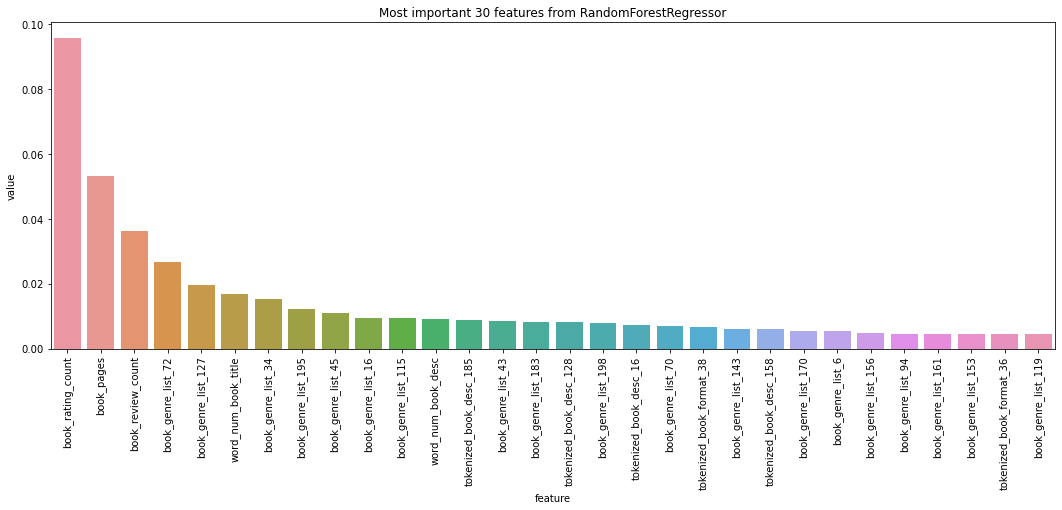

In [207]:
importances = list(rfr_result.feature_importances_)


feat_imp = dict((value, name) for value, name in zip(train_pipeline.columns, importances)) 
first_elem = 30

df_features = pd.DataFrame({'feature':list(feat_imp_sorted.keys())[:first_elem], 'value':list(feat_imp_sorted.values())[:first_elem] })

model_name = 'RandomForestRegressor'
title = f'Most important {first_elem} features from {model_name}'
barplot(df_features, title=title)

In [208]:
df_features

,feature,value
0,book_rating_count,0.095721
1,book_pages,0.053182
2,book_review_count,0.036335
3,book_genre_list_72,0.026673
4,book_genre_list_127,0.019721
5,word_num_book_title,0.016739
6,book_genre_list_34,0.015145
7,book_genre_list_195,0.012058
8,book_genre_list_45,0.010856
9,book_genre_list_16,0.009520


## GradientBoostingRegressor

In [76]:
gbr_result = GradientBoostingRegressor(loss='huber', max_depth=7, max_features='sqrt',
                          n_estimators=1000)

gbr_result.fit(train_sparsity, y_train)

name='GradientBoostingRegressor'
model = gbr_result
score_model = define_metrics(model, train_sparsity, test_sparsity, y_train, y_test, name)
score_model

,name,r2,MAPE,RMSE,ex_var,durbin_watson
0,GradientBoostingRegressor_train,0.738473,inf,0.189084,0.738886,2.004858
0,GradientBoostingRegressor_test,0.437915,inf,0.277070,0.439089,2.005696


In [78]:
model = gbr_result

final_predictions = model.predict(test_sparsity)
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([0.26594259, 0.28776824])

### features importance for GradientBoostingRegressor

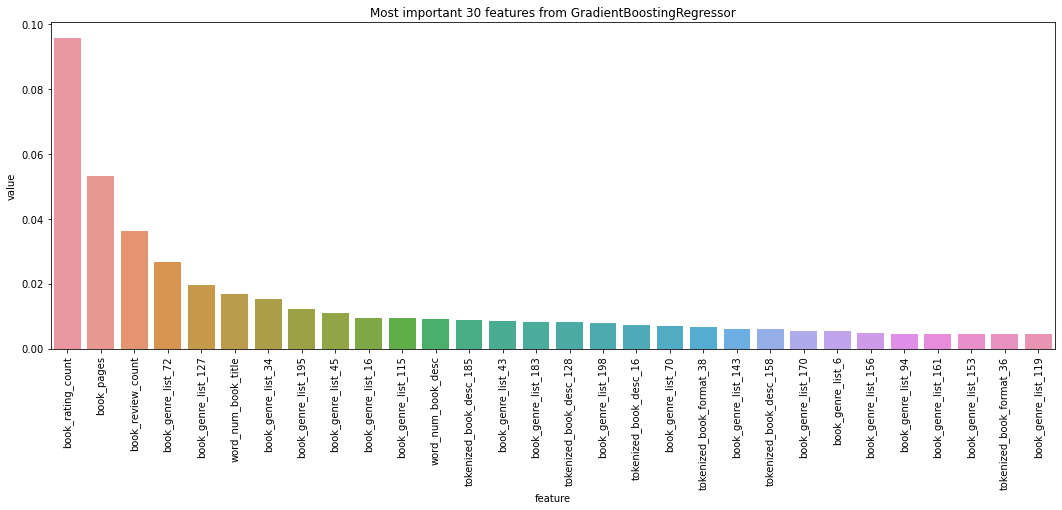

In [214]:
importances = list(gbr_result.feature_importances_)


feat_imp = dict((value, name) for value, name in zip(train_pipeline.columns, importances)) 
first_elem = 30

df_features = pd.DataFrame({'feature':list(feat_imp_sorted.keys())[:first_elem], 'value':list(feat_imp_sorted.values())[:first_elem] })

model_name = 'GradientBoostingRegressor'
title = f'Most important {first_elem} features from {model_name}'
barplot(df_features, title=title)

In [215]:
df_features

,feature,value
0,book_rating_count,0.095721
1,book_pages,0.053182
2,book_review_count,0.036335
3,book_genre_list_72,0.026673
4,book_genre_list_127,0.019721
5,word_num_book_title,0.016739
6,book_genre_list_34,0.015145
7,book_genre_list_195,0.012058
8,book_genre_list_45,0.010856
9,book_genre_list_16,0.009520


### Create submition

In [79]:
name = 'models/GradientBoostingRegressor'
dump(gbr_result, f'{name}.joblib') 

['models/GradientBoostingRegressor.joblib']

In [88]:
prediction = gbr_result.predict(submit_sparsity)

submition_res = pd.DataFrame({'id': list(submit_pipe.index), 'book_rating': prediction})
submition_res

In [89]:
submition_res.to_csv('submitions/GradientBoostingRegressor.csv', index=False)

## XGBRegressor

In [96]:
xgb_result = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=327, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

xgb_result.fit(train_sparsity, y_train)

name='XGBRegressor'
model = xgb_result
score_model = define_metrics(model, train_sparsity, test_sparsity, y_train, y_test, name)
score_model

,name,r2,MAPE,RMSE,ex_var,durbin_watson
0,XGBRegressor_train,0.637092,inf,0.222738,0.637092,2.012440
0,XGBRegressor_test,0.410307,inf,0.283793,0.410654,1.993273


In [97]:
model = xgb_result

final_predictions = model.predict(test_sparsity)
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([0.27284972, 0.29432999])

In [101]:
name = 'models/XGBRegressor'
dump(xgb_result, f'{name}.joblib') 

['models/XGBRegressor.joblib']

### features importance for XGBRegressor

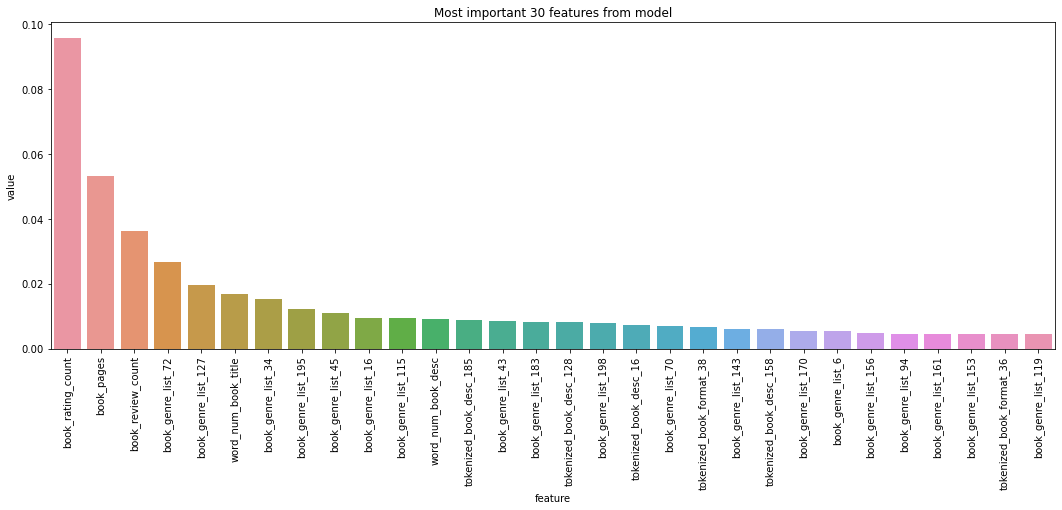

In [213]:
importances = list(xgb_result.feature_importances_)


feat_imp = dict((value, name) for value, name in zip(train_pipeline.columns, importances)) 
first_elem = 30

df_features = pd.DataFrame({'feature':list(feat_imp_sorted.keys())[:first_elem], 'value':list(feat_imp_sorted.values())[:first_elem] })

model_name = 'XGBRegressor'
title = f'Most important {first_elem} features from {model_name}'
barplot(df_features, title=title)

In [205]:
df_features

,feature,value
0,book_rating_count,0.095721
1,book_pages,0.053182
2,book_review_count,0.036335
3,book_genre_list_72,0.026673
4,book_genre_list_127,0.019721
5,word_num_book_title,0.016739
6,book_genre_list_34,0.015145
7,book_genre_list_195,0.012058
8,book_genre_list_45,0.010856
9,book_genre_list_16,0.009520


## Ensemble for models

In [116]:
%%time
name_model_1 = 'RandomForestRegressor'
name_model_2 = 'XGBRegressor'
name_model_3 = 'GradientBoostingRegressor'


clf1 =  RandomForestRegressor(n_jobs=-1)

clf2 = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=327, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


clf3 = GradientBoostingRegressor(loss='huber', max_depth=7, max_features='sqrt',
                          n_estimators=1000)


ensemble=VotingRegressor(estimators=[(name_model_1, clf1), 
                                      (name_model_2, clf2), 
                                      (name_model_3, clf3)],
                                      n_jobs=-1,
                          verbose=True).fit(train_sparsity, y_train)

name='ensemble'
model = ensemble
score_model = define_metrics(model, train_sparsity, test_sparsity, y_train, y_test, name)
score_model

CPU times: user 4.43 s, sys: 655 ms, total: 5.09 s
Wall time: 3min 15s


,name,r2,MAPE,RMSE,ex_var,durbin_watson
0,ensemble_train,0.796966,inf,0.166602,0.797021,2.007467
0,ensemble_test,0.450246,inf,0.274014,0.450786,1.999980


In [118]:
final_predictions = ensemble.predict(test_sparsity)
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([0.2631499 , 0.28446383])

In [119]:
name = 'models/ensemble3'
dump(ensemble, f'{name}.joblib') 

['models/ensemble3.joblib']

In [120]:
prediction = ensemble.predict(submit_sparsity)

submition_res = pd.DataFrame({'id': list(submit_pipe.index), 'book_rating': prediction})
submition_res

,id,book_rating
0,0,3.562545
1,1,3.668217
2,2,3.825486
3,3,3.863119
4,4,4.138831
...,...,...
3015,3015,3.961347
3016,3016,3.773998
3017,3017,3.833162
3018,3018,3.863211


In [121]:
submition_res.to_csv('submitions/ensemble3.csv', index=False)

# Deleting outliers

In [137]:
train_pipeline_new = train_pipeline.copy()
train_pipeline_new

,book_pages,book_review_count,book_rating_count,word_num_book_desc,word_num_book_format,word_num_book_title,tokenized_book_desc_0,tokenized_book_desc_1,tokenized_book_desc_2,tokenized_book_desc_3,...,tokenized_book_title_191,tokenized_book_title_192,tokenized_book_title_193,tokenized_book_title_194,tokenized_book_title_195,tokenized_book_title_196,tokenized_book_title_197,tokenized_book_title_198,tokenized_book_title_199,book_rating
0,320.0,624.0,3906.0,109.0,1.0,2.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.19
1,356.0,122.0,700.0,72.0,1.0,1.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.87
2,434.0,907.0,6709.0,114.0,1.0,3.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.67
3,358.0,160.0,4892.0,42.0,1.0,2.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.97
4,244.0,2.0,3.0,76.0,1.0,5.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,272.0,38.0,1676.0,95.0,1.0,3.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.98
35996,384.0,2324.0,14708.0,92.0,1.0,1.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.38
35997,352.0,912.0,5258.0,94.0,1.0,2.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.41
35998,224.0,55.0,1194.0,66.0,1.0,2.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.33


In [125]:
train_pipeline_new.describe(percentiles=[0.1, .25, .5, .75, .90, .95, .99])

,book_pages,book_review_count,book_rating_count,word_num_book_desc,word_num_book_format,word_num_book_title,tokenized_book_desc_0,tokenized_book_desc_1,tokenized_book_desc_2,tokenized_book_desc_3,...,tokenized_book_title_191,tokenized_book_title_192,tokenized_book_title_193,tokenized_book_title_194,tokenized_book_title_195,tokenized_book_title_196,tokenized_book_title_197,tokenized_book_title_198,tokenized_book_title_199,book_rating
count,36000.000000,36000.000000,3.600000e+04,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,...,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000
mean,325.188306,1545.077194,3.403125e+04,86.188778,1.216639,2.960944,0.015405,0.013384,0.007578,0.011265,...,0.001853,0.002708,0.002131,0.005062,0.001736,0.001995,0.009092,0.001917,0.004236,4.008780
std,230.234451,7004.624968,1.997492e+05,58.333154,0.512068,2.201779,0.070043,0.060748,0.053450,0.061895,...,0.039753,0.048818,0.042951,0.063133,0.039234,0.039683,0.083005,0.039965,0.059059,0.369744
min,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,128.000000,5.000000,3.500000e+01,28.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.610000
25%,216.000000,28.000000,3.060000e+02,50.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.810000
50%,310.000000,131.000000,1.888000e+03,78.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.010000
75%,384.000000,470.000000,6.945500e+03,109.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.210000
90%,512.000000,1816.000000,2.493310e+04,149.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.400000
95%,629.000000,5989.600000,9.111320e+04,182.000000,2.000000,7.000000,0.153477,0.134715,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.550000


In [126]:
train_pipeline_new.shape

(36000, 906)

(35691, 906)


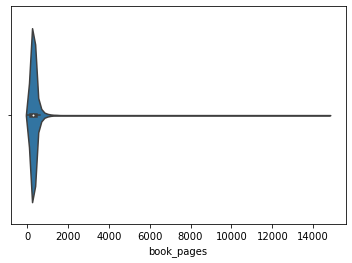

In [138]:
sns.violinplot(train_pipeline_new['book_pages'])
Q1 = train_pipeline_new['book_pages'].quantile(0.1)
Q3 = train_pipeline_new['book_pages'].quantile(0.9)
IQR = Q3 - Q1
train_pipeline_new = train_pipeline_new[(train_pipeline_new['book_pages'] >= Q1 - 1.5*IQR) & 
                      (train_pipeline_new['book_pages'] <= Q3 + 1.5*IQR)]
print(train_pipeline_new.shape)
plt.show()

(33578, 906)


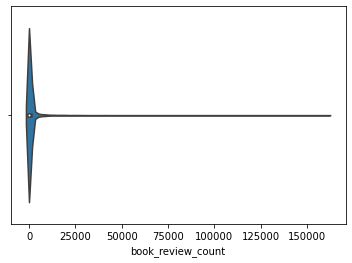

In [139]:
sns.violinplot(train_pipeline_new['book_review_count'])
Q1 = train_pipeline_new['book_review_count'].quantile(0.1)
Q3 = train_pipeline_new['book_review_count'].quantile(0.9)
IQR = Q3 - Q1
train_pipeline_new = train_pipeline_new[(train_pipeline_new['book_review_count'] >= Q1 - 1.5*IQR) & 
                      (train_pipeline_new['book_review_count'] <= Q3 + 1.5*IQR)]
print(train_pipeline_new.shape)
plt.show()

(32675, 906)


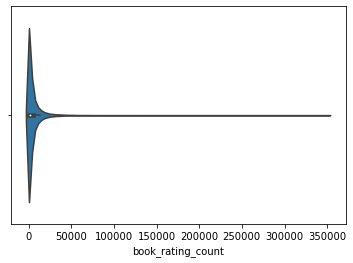

In [140]:
sns.violinplot(train_pipeline_new['book_rating_count'])
Q1 = train_pipeline_new['book_rating_count'].quantile(0.1)
Q3 = train_pipeline_new['book_rating_count'].quantile(0.9)
IQR = Q3 - Q1
train_pipeline_new = train_pipeline_new[(train_pipeline_new['book_rating_count'] >= Q1 - 1.5*IQR) & 
                      (train_pipeline_new['book_rating_count'] <= Q3 + 1.5*IQR)]
print(train_pipeline_new.shape)
plt.show()

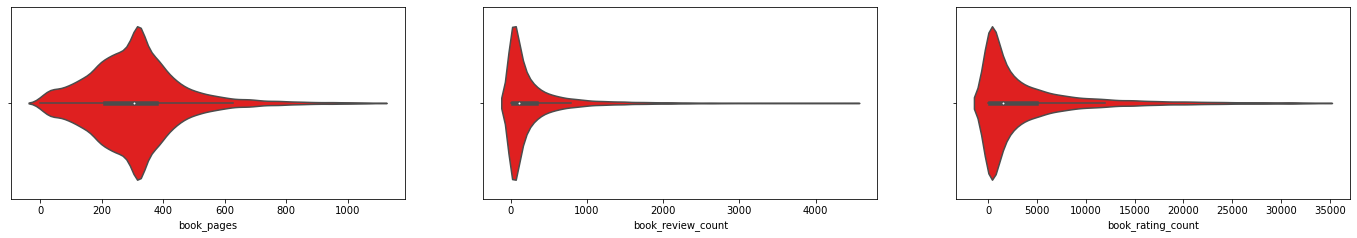

In [141]:
# Violinplot for numeric varaibles
plt.figure(figsize=(24, 12))
plt.subplot(3,3,1)
sns.violinplot(train_pipeline_new.book_pages, fill='#A4A4A4', color="red")
plt.subplot(3,3,2)
sns.violinplot(train_pipeline_new.book_review_count, fill='#A4A4A4', color="red")
plt.subplot(3,3,3)
sns.violinplot(train_pipeline_new.book_rating_count, fill='#A4A4A4', color="red")

## Tuning models

In [143]:
train_pipeline_new

,book_pages,book_review_count,book_rating_count,word_num_book_desc,word_num_book_format,word_num_book_title,tokenized_book_desc_0,tokenized_book_desc_1,tokenized_book_desc_2,tokenized_book_desc_3,...,tokenized_book_title_191,tokenized_book_title_192,tokenized_book_title_193,tokenized_book_title_194,tokenized_book_title_195,tokenized_book_title_196,tokenized_book_title_197,tokenized_book_title_198,tokenized_book_title_199,book_rating
0,320.0,624.0,3906.0,109.0,1.0,2.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.19
1,356.0,122.0,700.0,72.0,1.0,1.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.87
2,434.0,907.0,6709.0,114.0,1.0,3.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.67
3,358.0,160.0,4892.0,42.0,1.0,2.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.97
4,244.0,2.0,3.0,76.0,1.0,5.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,272.0,38.0,1676.0,95.0,1.0,3.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.98
35996,384.0,2324.0,14708.0,92.0,1.0,1.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.38
35997,352.0,912.0,5258.0,94.0,1.0,2.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.41
35998,224.0,55.0,1194.0,66.0,1.0,2.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.33


In [144]:
train_sparsity_new = sparse.csc_matrix(train_pipeline_new.drop(['book_rating'], axis=1))
y_train_new = train_pipeline_new.book_rating

## Tuning parametrs

In [ ]:
%%time
models = []

# models.append(('LogisticRegression', LogisticRegression()))
# models.append(('SGDRegressor', SGDRegressor()))
# models.append(('LinearSVR', LinearSVR()))
# models.append(('SGDRegressor', SGDRegressor()))
models.append(('GradientBoostingRegressor', GradientBoostingRegressor()))
models.append(('RandomForestRegressor', RandomForestRegressor()))
models.append(('XGBRegressor', XGBRegressor()))
models.append(('XGBRFRegressor', XGBRFRegressor()))
# models.append(('SVR', SVR()))

box_plot, df_means = get_score_for_model(models, train_sparsity_new, y_train_new, n_splits=3,scoring='neg_mean_absolute_error', print_res=True)

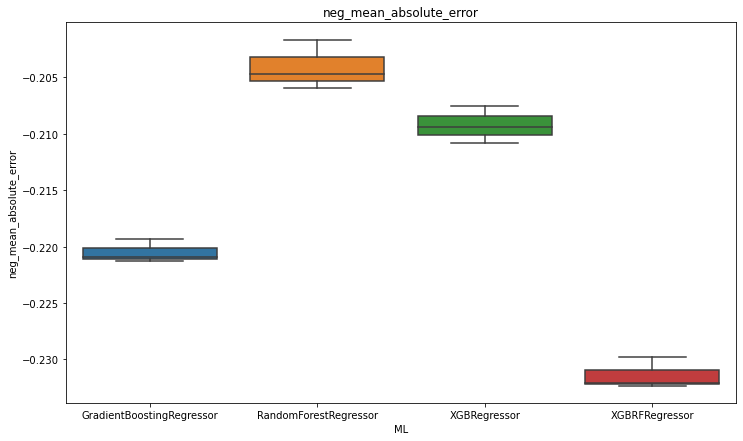

In [160]:
plt.figure(figsize=(12,7))
plt.title("neg_mean_absolute_error")
sns.boxplot(data = box_plot, x = box_plot.columns[1],y=box_plot.columns[0]);

# Train separately

## RandomForestRegressor

In [145]:
rfr_result_new = RandomForestRegressor(n_jobs=-1)
rfr_result_new.fit(train_sparsity_new, y_train_new)

name='RandomForestRegressor'
model = rfr_result_new
score_model = define_metrics(model, train_sparsity_new, test_sparsity, y_train_new, y_test, name)
score_model

,name,r2,MAPE,RMSE,ex_var,durbin_watson
0,RandomForestRegressor_train,0.92080,1.984055,0.10663,0.920802,2.011683
0,RandomForestRegressor_test,0.41227,NaN,0.28332,0.412345,2.006647


In [146]:
model = rfr_result_new

final_predictions = model.predict(test_sparsity)
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([0.27292257, 0.29334986])

### features importance for RandomForestRegressor

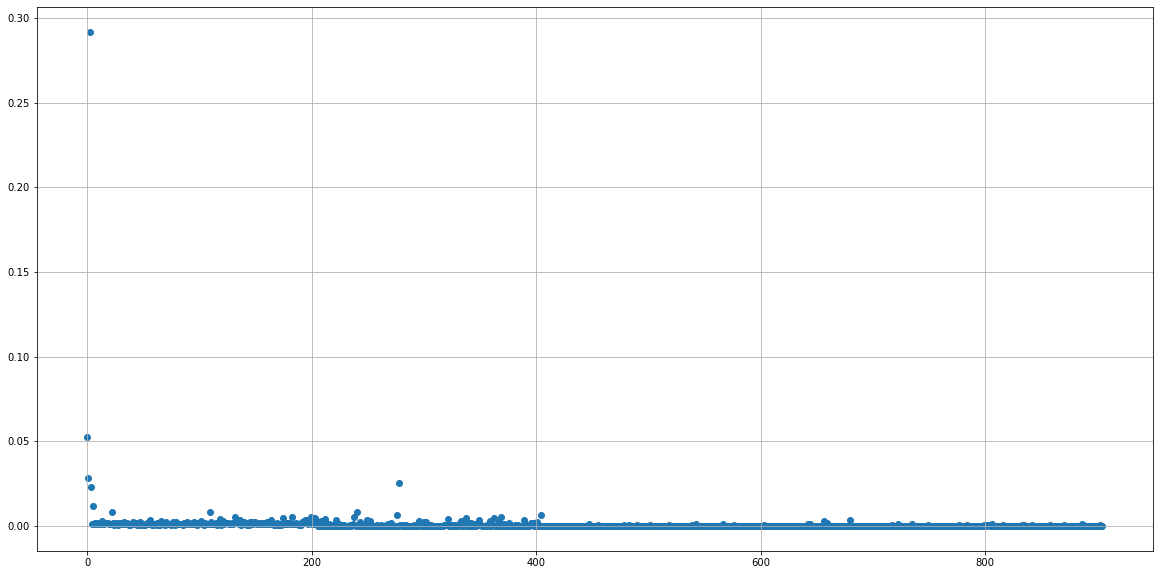

In [115]:
x_plot = list(range(len(rfr_result_new.feature_importances_)))
importances = list(rfr_result_new.feature_importances_)

plt.figure(figsize=(20,10))
plt.grid(True)
plt.scatter(x_plot,importances)
plt.show()

## GradientBoostingRegressor

In [147]:
gbr_result_new = GradientBoostingRegressor(loss='huber', max_depth=7, max_features='sqrt',
                          n_estimators=1000)

gbr_result_new.fit(train_sparsity_new, y_train_new)

name='GradientBoostingRegressor'
model = gbr_result_new
score_model = define_metrics(model, train_sparsity_new, test_sparsity, y_train_new, y_test, name)
score_model

,name,r2,MAPE,RMSE,ex_var,durbin_watson
0,GradientBoostingRegressor_train,0.754006,inf,0.187922,0.754391,2.010036
0,GradientBoostingRegressor_test,0.409704,inf,0.283938,0.410099,2.002332


In [148]:
model = gbr_result_new

final_predictions = model.predict(test_sparsity)
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([0.27256576, 0.29487235])

### features importance for GradientBoostingRegressor

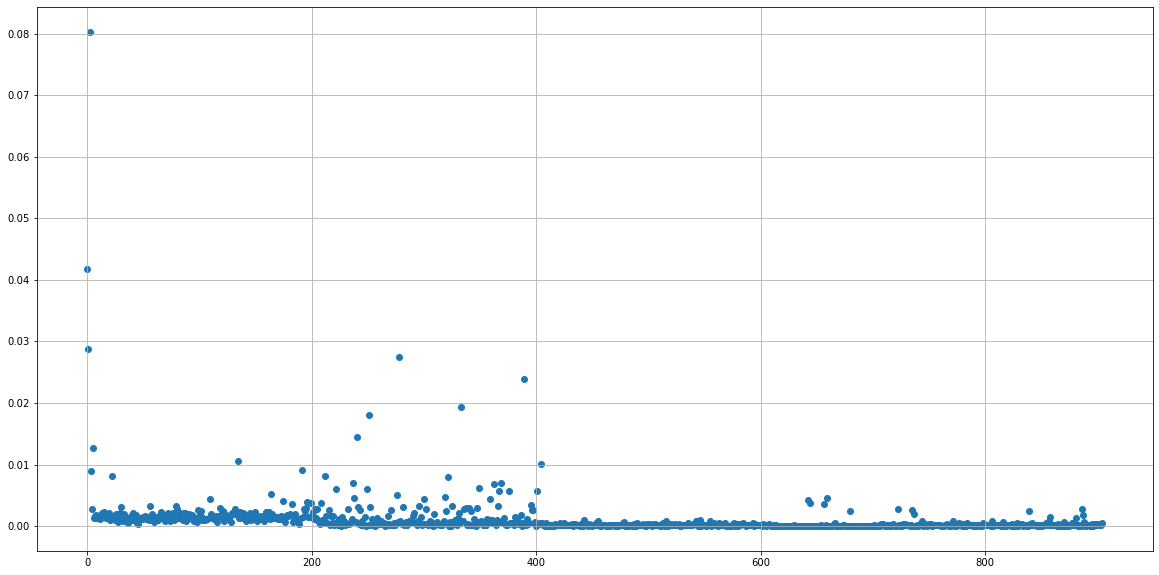

In [149]:
x_plot = list(range(len(gbr_result_new.feature_importances_)))
importances = list(gbr_result_new.feature_importances_)

plt.figure(figsize=(20,10))
plt.grid(True)
plt.scatter(x_plot,importances)
plt.show()

### Create submition

In [79]:
name = 'models/GradientBoostingRegressor_new'
dump(gbr_result_new, f'{name}.joblib') 

['models/GradientBoostingRegressor.joblib']

In [88]:
prediction = gbr_result.predict(submit_sparsity)

submition_res = pd.DataFrame({'id': list(submit_pipe.index), 'book_rating': prediction})
submition_res

In [89]:
submition_res.to_csv('submitions/GradientBoostingRegressor.csv', index=False)

## XGBRegressor

In [152]:
xgb_result_new = XGBRegressor()

xgb_result_new.fit(train_sparsity_new, y_train_new)

name='XGBRegressor'
model = xgb_result_new
score_model = define_metrics(model, train_sparsity_new, test_sparsity, y_train_new, y_test, name)
score_model

,name,r2,MAPE,RMSE,ex_var,durbin_watson
0,XGBRegressor_train,0.618827,inf,0.233925,0.618827,2.011954
0,XGBRegressor_test,-5.143168,inf,0.915978,-4.878503,1.900145


In [154]:
model = xgb_result_new

final_predictions = model.predict(test_sparsity)
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([0.85806484, 0.97044164])

In [101]:
name = 'models/XGBRegressor_new'
dump(xgb_result_new, f'{name}.joblib') 

['models/XGBRegressor.joblib']

### features importance for XGBRegressor

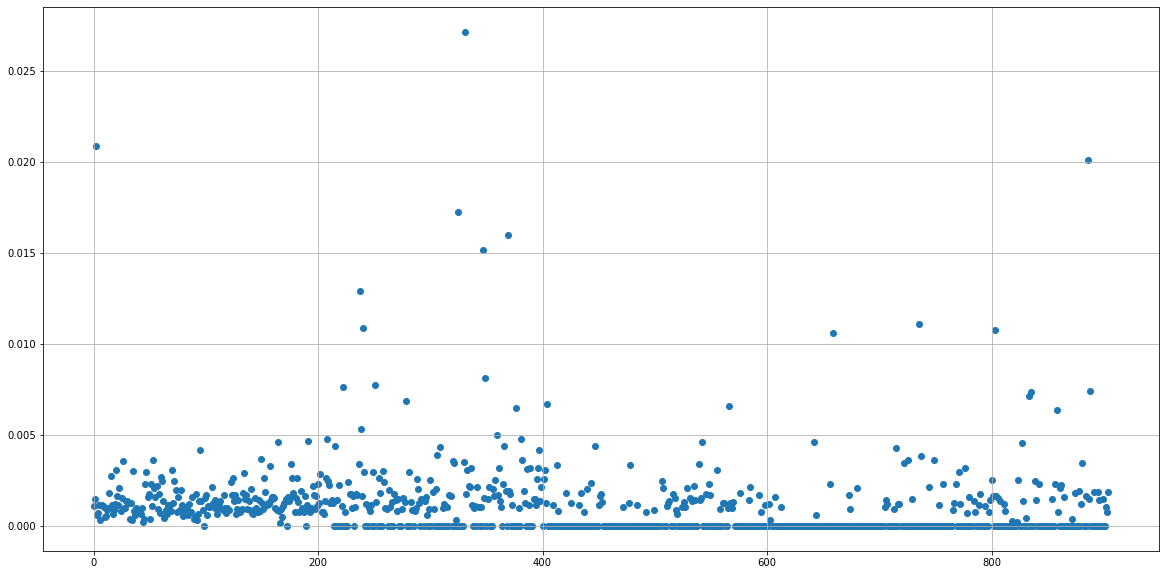

In [155]:
x_plot = list(range(len(xgb_result_new.feature_importances_)))
importances = list(xgb_result_new.feature_importances_)

plt.figure(figsize=(20,10))
plt.grid(True)
plt.scatter(x_plot,importances)
plt.show()

## Ensemble for models

In [156]:
%%time
name_model_1 = 'RandomForestRegressor'
# name_model_2 = 'XGBRegressor'
name_model_3 = 'GradientBoostingRegressor'


clf1 =  RandomForestRegressor(n_jobs=-1)

# clf2 = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#              colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
#              gpu_id=-1, importance_type='gain', interaction_constraints='',
#              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
#              min_child_weight=1, monotone_constraints='()',
#              n_estimators=327, n_jobs=-1, num_parallel_tree=1, random_state=0,
#              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
#              tree_method='exact', validate_parameters=1, verbosity=None)


clf3 = GradientBoostingRegressor(loss='huber', max_depth=7, max_features='sqrt',
                          n_estimators=1000)


ensemble_new=VotingRegressor(estimators=[(name_model_1, clf1), 
                                      (name_model_2, clf2), 
                                      (name_model_3, clf3)],
                                      n_jobs=-1,
                          verbose=True).fit(train_sparsity, y_train)

name='ensemble_new'
model = ensemble_new
score_model = define_metrics(model, train_sparsity, test_sparsity, y_train, y_test, name)
score_model

CPU times: user 4.44 s, sys: 663 ms, total: 5.11 s
Wall time: 3min 15s


,name,r2,MAPE,RMSE,ex_var,durbin_watson
0,ensemble_new_train,0.797642,inf,0.166324,0.797697,2.008655
0,ensemble_new_test,0.451566,inf,0.273685,0.452155,2.004755


In [157]:
final_predictions = ensemble_new.predict(test_sparsity)
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([0.26297654, 0.28399014])

In [158]:
name = 'models/ensemble3_new'
dump(ensemble, f'{name}.joblib') 

['models/ensemble3_new.joblib']

In [120]:
prediction = ensemble.predict(submit_sparsity)

submition_res = pd.DataFrame({'id': list(submit_pipe.index), 'book_rating': prediction})
submition_res

,id,book_rating
0,0,3.562545
1,1,3.668217
2,2,3.825486
3,3,3.863119
4,4,4.138831
...,...,...
3015,3015,3.961347
3016,3016,3.773998
3017,3017,3.833162
3018,3018,3.863211


In [161]:
submition_res.to_csv('submitions/ensemble3_new.csv', index=False)